This code analyses data that Jenny acquired. She ran 3 flies, which got a 5 min trial each. The trial started with a blue bar in closed-loop with the animal, and some time into the trial, the panels were turned off and the fly was left in the darkness. A few minutes after that, the panels were turned on and the animal was once again faced with a blue bar in closed-loop. While the animals were undergoing this behavioral paradigm, she imaged their EPG cells in the PB, which expressed GCaMP6f or GCaMP7f. She used 60D05-Gal4 flies.
We are interested in seeing the differences in the EPG bump between what we will define as 'certain' and 'uncertain' states (reliable landmark in closed-loop, and darkness, respectively).

In [1]:
#Import all the modules we will be using

import os #import module to view and manipulate directories
import scipy.io as sio #import module to open matlab files
import matplotlib.pyplot as plt #import the plotting module
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from scipy.stats import circstd, pearsonr
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy.stats import vonmises, vonmises_line
from tqdm import tqdm, tqdm_gui
from astropy.stats import circcorrcoef

In [2]:
#Load data for single analyses
mainDir = os.getcwd()[:-7]

In [3]:
files = os.listdir(mainDir + '\data')  #get the list of folders in it
folders = []
for file in range(len(files)):
    if os.path.isdir(mainDir + "\data\\" + files[file]):
        folders.append(files[file])
flyNum = len(folders) #determine fly number

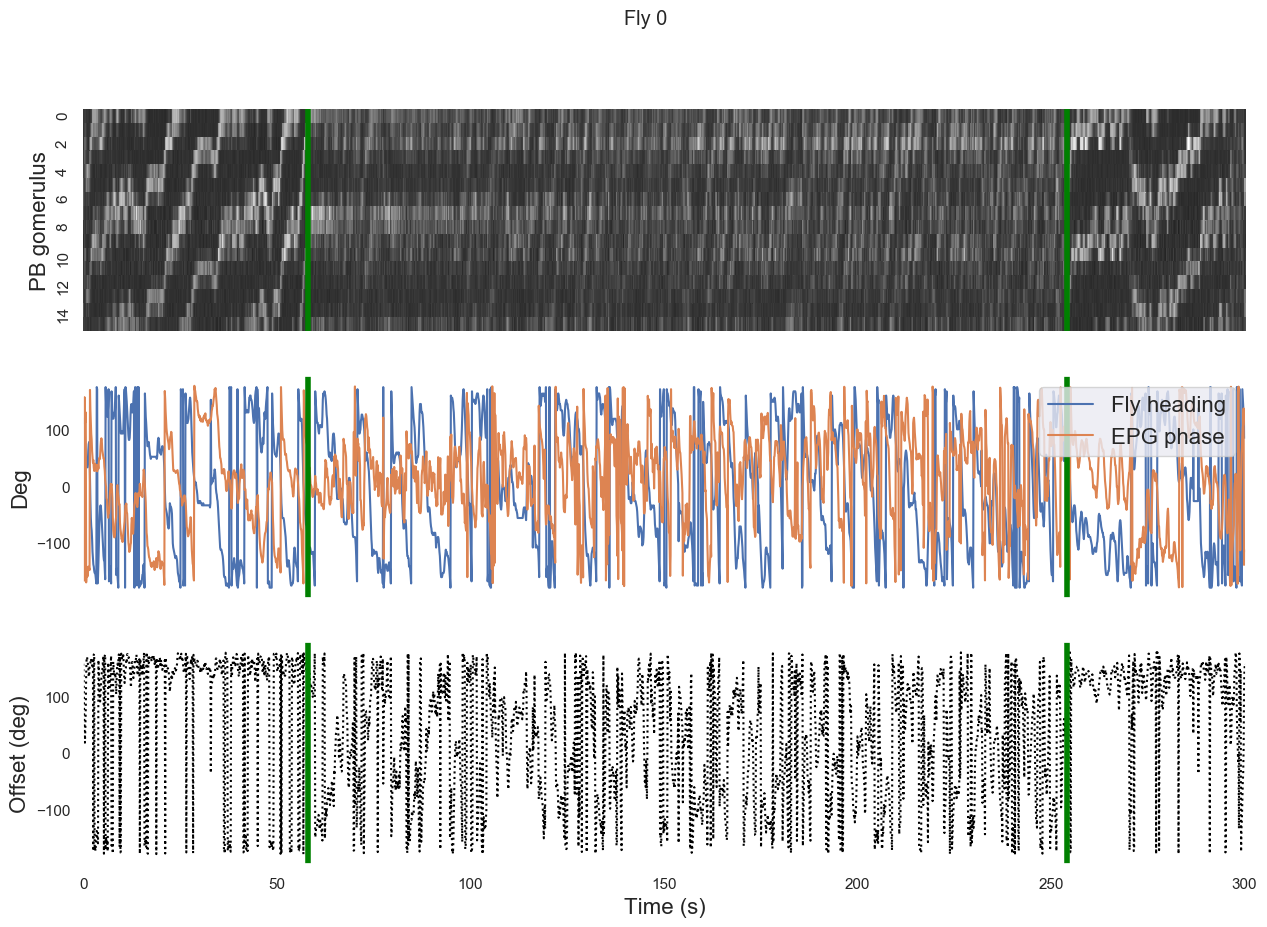

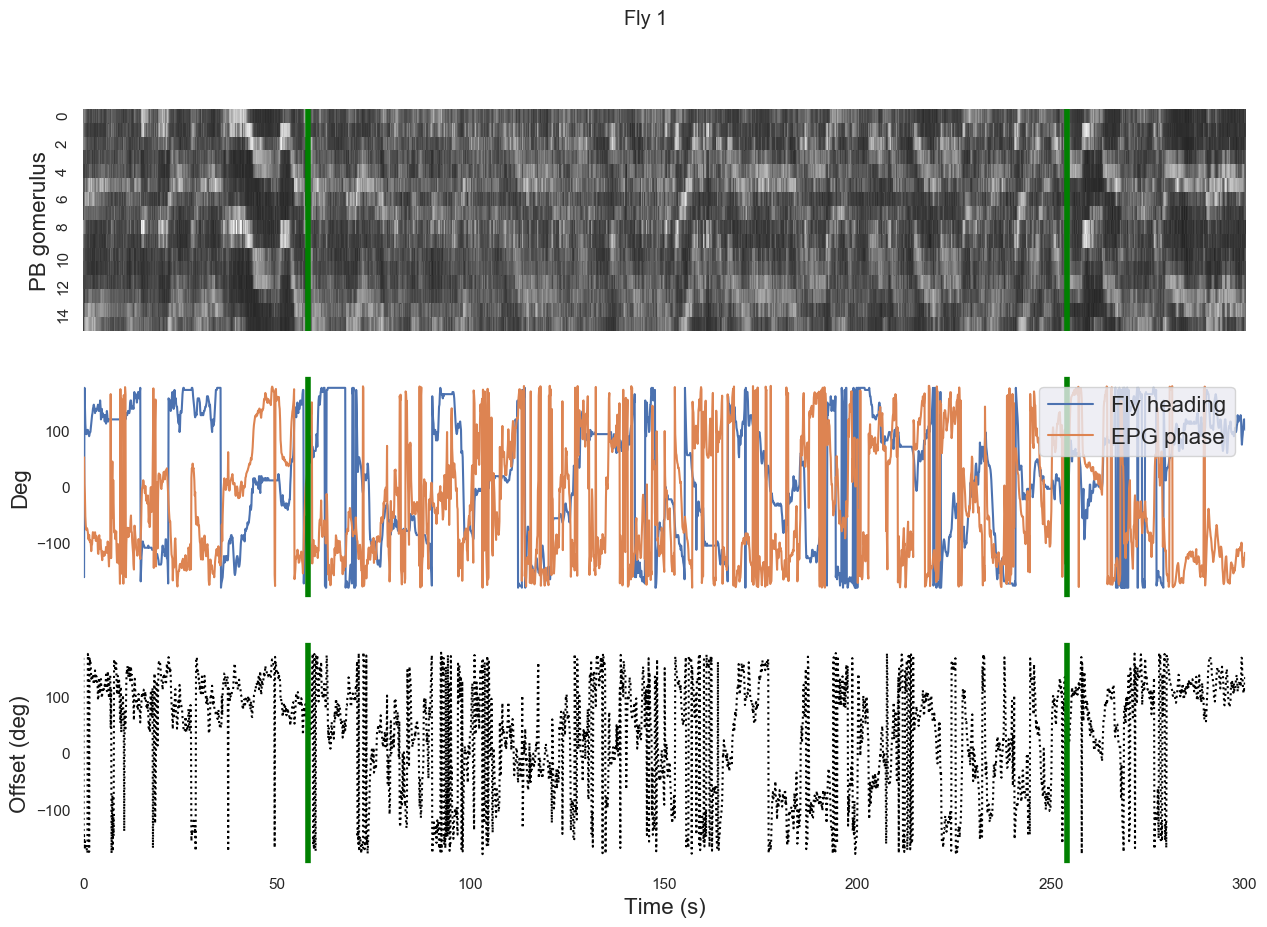

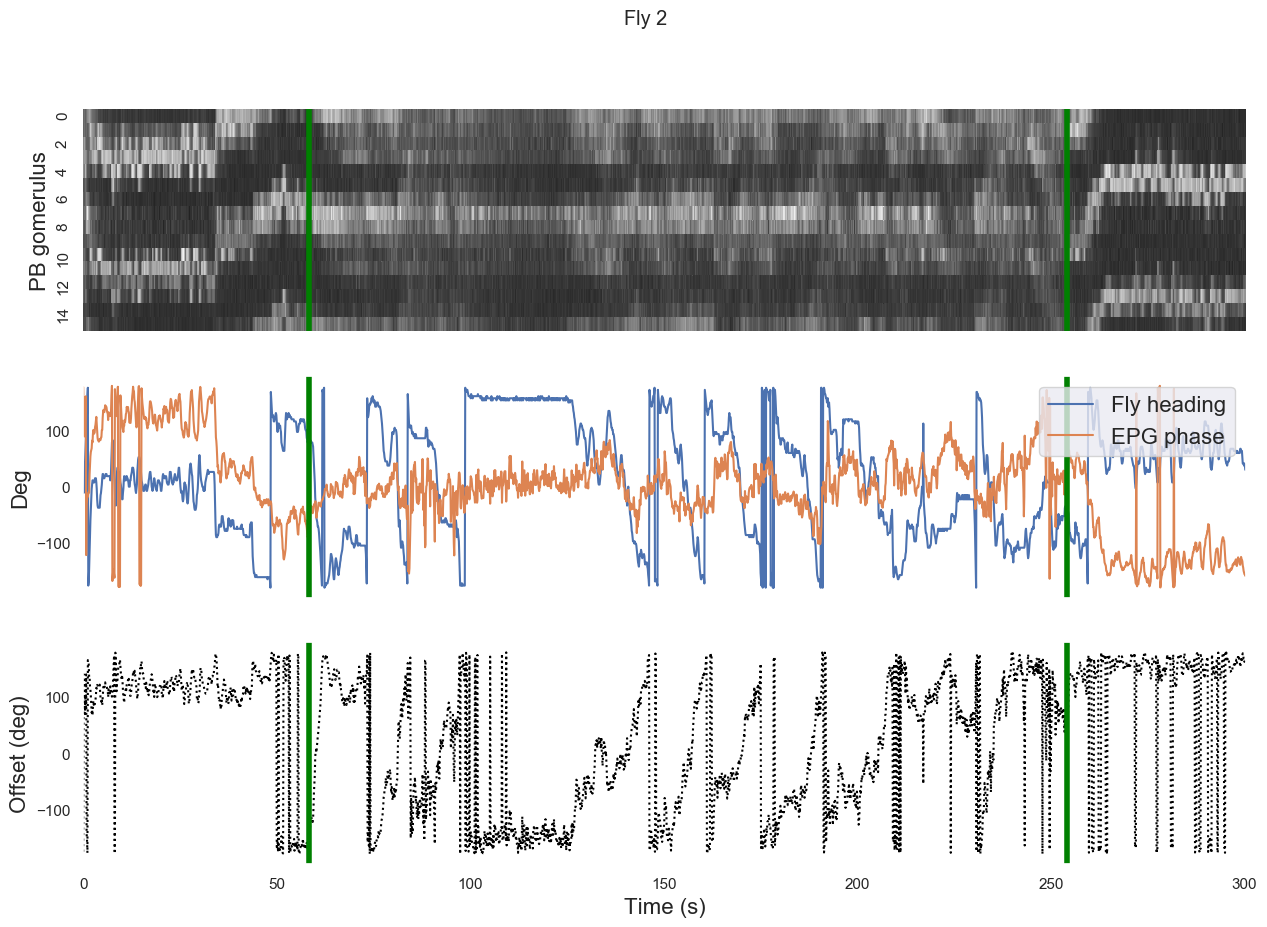

In [4]:
#For each fly, plot the heatmap for the neural data, the fly heading and EPG phase, and the offset

for fly in range(flyNum): #for each of the folders
    os.chdir(mainDir + '\data\\' + folders[fly] + '\\dark trial') #move inside of the folder, inside the dark trial folder
    file = os.listdir() #get the file names
    data = sio.loadmat(file[0], struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
    flyData = data['data'] #store only the data from that dictionnary object into a new object called flyData. This is now a numpy.ndarray
    
    #Find where the panels are turned off and then on
    panelOFF = np.array(np.where(flyData[0,0].fr_y_ds == 1)) #I don't understand why panelOFF has 2 rows. The second one just has zeros. Is there a way to avoid it?
    StartDark = panelOFF[0,0]
    EndDark = panelOFF[0,-1]
    
    #plot heatmap of neural activity
    dff_matrix = flyData[0,0].dff_matrix
    my_cmap = sns.dark_palette("white", as_cmap=True)
    
    fig,(ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15, 10), dpi=100)
    #grid_kws = {"height_ratios": (.05, .9, .9, .9), "hspace": .3}
    #f, (cbar_ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize = (15, 10), dpi=100, gridspec_kw=grid_kws)
    
    fig.suptitle('Fly ' + str(fly))
    g = sns.heatmap(dff_matrix,cmap=my_cmap,ax=ax1, cbar=False)
    #g = sns.heatmap(dff_matrix,cmap=my_cmap,ax=ax1, cbar_kws = dict(use_gridspec=False,location="top"))#cbar=False)
    #g = sns.heatmap(dff_matrix,cmap=my_cmap,ax=ax1, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})    
    g.set_yticklabels=[]
    g.set_ylabel('PB gomerulus', fontsize=16)
    ax1.axvline(x=StartDark, color='green', lw = 4)
    ax1.axvline(x=EndDark, color='green', lw = 4)
    plt.setp(ax1.get_xticklabels(), visible=False)
     
    ax2 = plt.subplot(312, sharex=ax1)
    ax2.plot(np.transpose(np.rad2deg(flyData[0,0].panel_angle)))   
    ax2.plot(np.transpose(np.rad2deg(flyData[0,0].phase)))   
    ax2.set(xticklabels=[])
    plt.ylabel('Deg', fontsize=16)
    ax2.set_facecolor('white') 
    ax2.axvline(x=StartDark, color='green', lw = 4)
    ax2.axvline(x=EndDark, color='green', lw = 4) 
    ax2.legend(('Fly heading', 'EPG phase'),loc='upper right', prop={'size': 16})
    plt.setp(ax2.get_xticklabels(), visible=False)   
    
    ax3 = plt.subplot(313, sharex = ax1)
    ax3.plot(np.transpose((np.rad2deg(flyData[0,0].offset))),color ='black',linestyle=':')    
    ax3.set_facecolor('white')
    ax3.axvline(x=StartDark, color='green', lw = 4)
    ax3.axvline(x=EndDark, color='green', lw = 4) 
    plt.ylabel('Offset (deg)', fontsize=16)
    plt.xlabel('Time (s)', fontsize=16)
    x_locations = np.arange(0, len(flyData[0,0].time), 458)
    ax3.set_xticks(x_locations)
    ax3.set_xticklabels(('0','50','100','150','200','250','300'))
    plt.savefig(mainDir + "\plots\IndividualPlotsFly"  + str(fly) + ".png", dpi=150)

    #add colorbar without shrinking the heatmap (I managed to do it with the comment lines, but the layout is still a bit weird, with the writing on top)

     

In [6]:
# Load group data

groupData = sio.loadmat(mainDir + '\data\\allDarkData.mat', struct_as_record=True)
flyGroupData = groupData['Data']

#To access the fields in flyGroupData, use flyGroupData.dtype

We call 'offset' the difference between the actual heading of the fly, and the phase value of the EPG network for eery time frame. When animals are given a landmark, such as a bright bar, the offset, even though it differs from fly to fly, becomes pretty stable after the fly has been on the ball for some time. In the darkness, the offset drifts with time. Next, we will look at the offset distributions under certain and undertain conditions.

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In

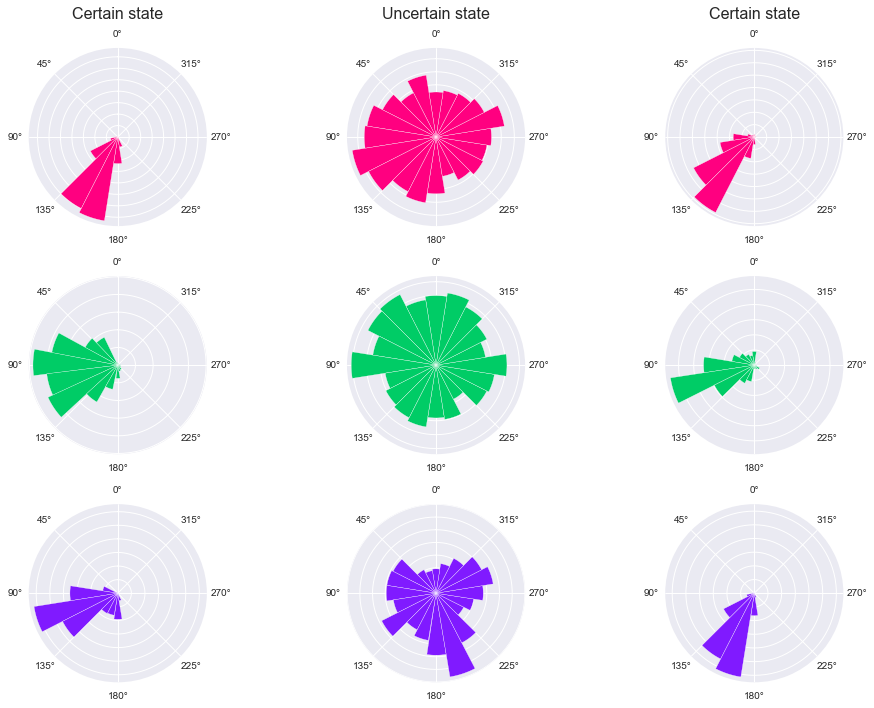

In [7]:
# Plot the offset distribution for each fly

# Set color palette for flies
palette = [(1,0,0.5),(0,0.8,0.4),(0.5,0.1,1)]
    
plt.style.use('seaborn')

bins_number = 20
width = 2 * np.pi / bins_number

fig = plt.figure()

for fly in range(flyNum):
    angles1 = flyGroupData[0,fly]['offset'][0,0:StartDark]    
    angles2 = flyGroupData[0,fly]['offset'][0,StartDark:EndDark]
    angles3 = flyGroupData[0,fly]['offset'][0,EndDark:]
    
    ax = fig.add_subplot(3, 3, fly+1+2*fly)
    polar_ax = fig.add_subplot(3, 3, fly+1+2*fly, projection="polar")
    # bin data for our polar histogram
    count, bin = np.histogram(angles1, bins=bins_number)
    # Plot polar histogram
    polar_ax.bar(bin[:-1], count, align='center', width=width, color = palette[fly])
    polar_ax.set_yticklabels([])
    polar_ax.set_theta_zero_location("N")

    ax2 = fig.add_subplot(3, 3, fly+2+2*fly)
    polar_ax2 = fig.add_subplot(3, 3, fly+2+2*fly, projection="polar")
    count2, bin = np.histogram(angles2, bins=bins_number)
    polar_ax2.bar(bin[:-1], count2, align='center', width=width, color = palette[fly])
    polar_ax2.set_yticklabels([])
    polar_ax2.set_theta_zero_location("N")
    
    ax3 = fig.add_subplot(3, 3, fly+3+2*fly)
    polar_ax3 = fig.add_subplot(3, 3, fly+3+2*fly, projection="polar")
    count3, bin = np.histogram(angles3, bins=bins_number)
    polar_ax3.bar(bin[:-1], count3, align='center', width=width, color = palette[fly])
    polar_ax3.set_yticklabels([])
    polar_ax3.set_theta_zero_location("N")
    
    if fly == 0:
        polar_ax.set_title('Certain state', pad=20, fontsize=16)    
        polar_ax2.set_title('Uncertain state', pad=20, fontsize=16)
        polar_ax3.set_title('Certain state', pad=20, fontsize=16)
    
    fig.tight_layout()
    plt.gcf().set_size_inches(15, 10)
    plt.savefig(mainDir + "\\plots\PolarHistOffset.png", dpi=150)

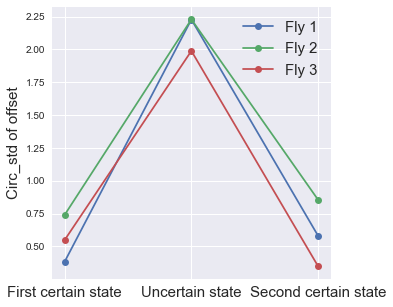

In [8]:
# Get and plot offset variation in each case
# We are going to quantify the trends observed in the previous plot by calculating the circular standard deviation per state for each fly.

offset_variation = np.empty([3, 3])

for fly in range(flyNum):
    offset_variation[fly,0] = circstd(flyGroupData[0,fly]['offset'][0,0:StartDark])
    offset_variation[fly,1] = circstd(flyGroupData[0,fly]['offset'][0,StartDark:EndDark])
    offset_variation[fly,2] = circstd(flyGroupData[0,fly]['offset'][0,EndDark:])
    
offset_variation = np.transpose(offset_variation)

plt.plot(offset_variation,marker="o")
plt.ylabel('Circ_std of offset',fontsize=15)
#plt.title('Offset variation across states',fontsize=20)
plt.xticks([0,1,2], ['First certain state','Uncertain state','Second certain state'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'],fontsize=15)
plt.gcf().set_size_inches(5, 5)
plt.savefig(mainDir + "\\plots\OffsetVariationPy.png", dpi=150)

#set colors as in palette

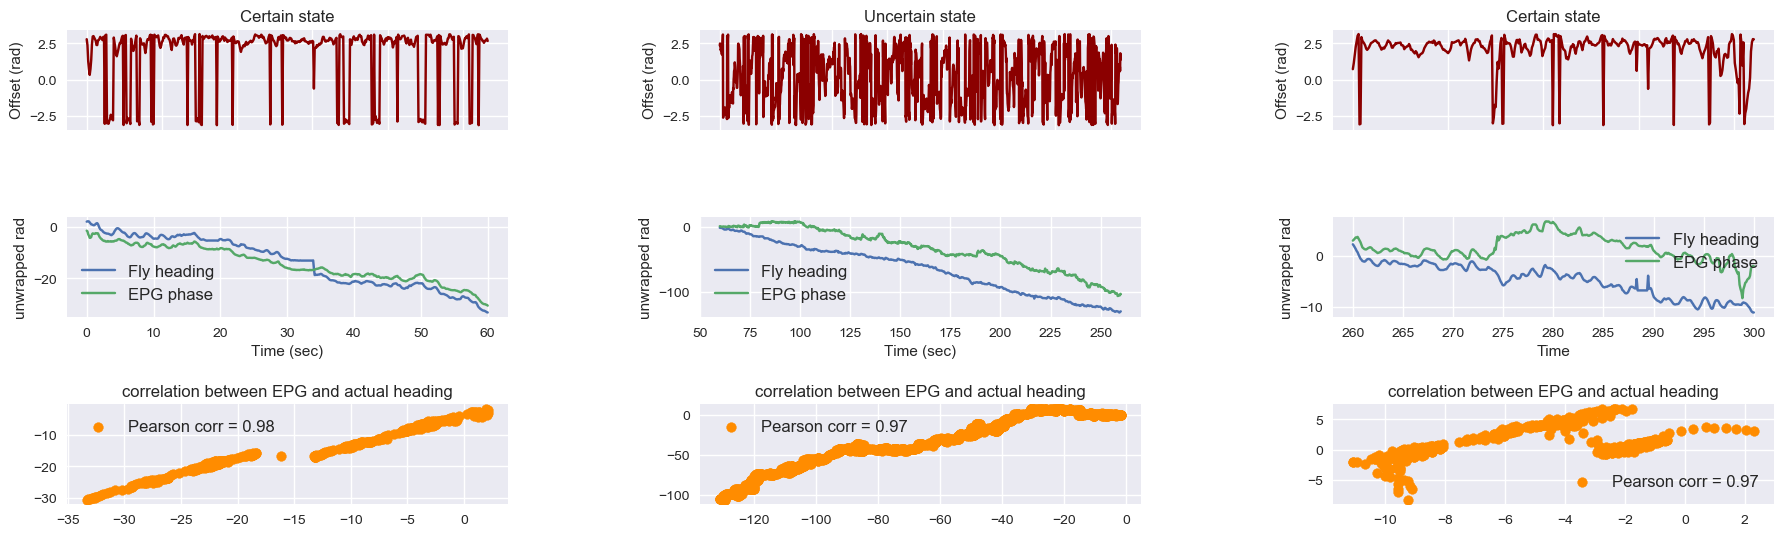

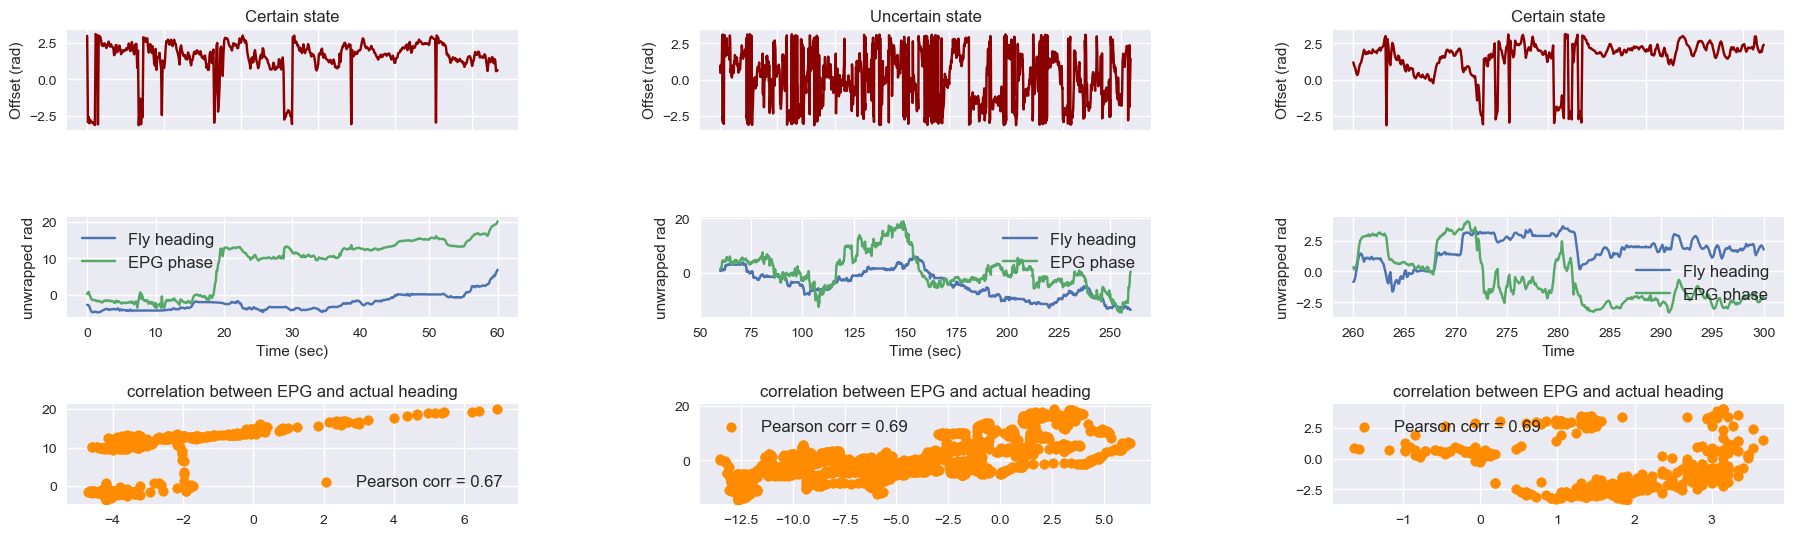

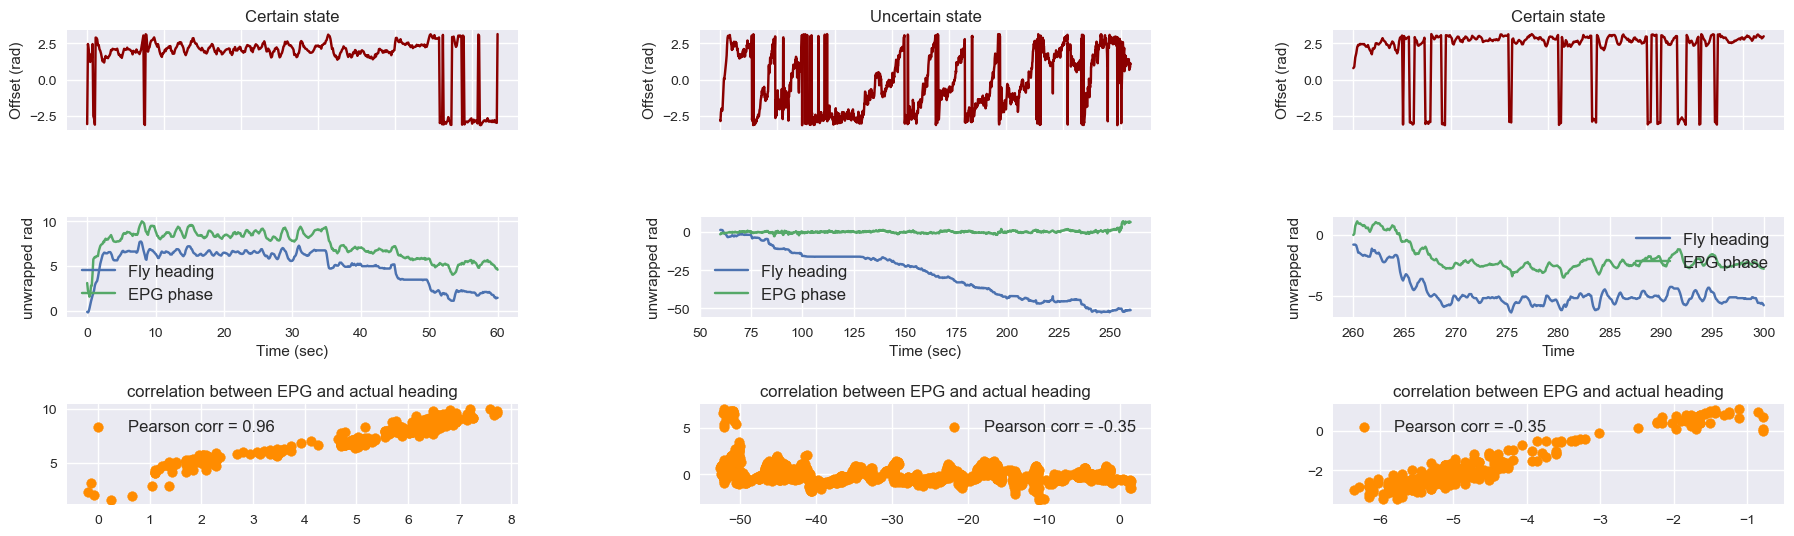

In [9]:
#1) Using the Seelig 2015 method
#Pearson's correlation coefficients were computed between two entire 'unwrapped' time series
#repeat for every fly and state

dataCorr = np.zeros((flyNum,3))

for fly in range(flyNum):
    fig, axs = plt.subplots(3,3, figsize = (15, 10), dpi=100)
    
    axs[0,0].plot(flyGroupData[0,fly]['offset'][0,0:StartDark],color='darkred')
    axs[0,0].set(ylabel='Offset (rad)')
    axs[0,0].set_xticklabels('')
    
    actualHeading = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,0:StartDark])
    decodedHeading = np.unwrap(flyGroupData[0,fly]['phase_value'][0,0:StartDark])   
    axs[1,0].plot(np.linspace(0,60,len(actualHeading)), actualHeading)
    axs[1,0].plot(np.linspace(0,60,len(actualHeading)),decodedHeading)
    axs[1,0].set(ylabel='unwrapped rad')
    axs[1,0].set(xlabel='Time (sec)')
    axs[1,0].legend(['Fly heading', 'EPG phase'], prop={'size': 12})

    axs[2,0].scatter(actualHeading,decodedHeading,color='darkorange')
    axs[2,0].set(title='correlation between EPG and actual heading')
    #get correlation
    dataCorr[fly,0] = pearsonr(actualHeading,decodedHeading)[0]
    axs[2,0].legend(['Pearson corr = ' + str(round(dataCorr[fly,0],2))], prop={'size': 12})
    
    axs[0,1].plot(flyGroupData[0,fly]['offset'][0,StartDark:EndDark],color='darkred')
    axs[0,1].set(ylabel='Offset (rad)')
    axs[0,1].set_xticklabels('')
    
    actualHeading = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,StartDark:EndDark])
    decodedHeading = np.unwrap(flyGroupData[0,fly]['phase_value'][0,StartDark:EndDark])
    axs[1,1].plot(np.linspace(60,260,len(actualHeading)),actualHeading)
    axs[1,1].plot(np.linspace(60,260,len(actualHeading)),decodedHeading)
    axs[1,1].set(ylabel='unwrapped rad')
    axs[1,1].set(xlabel='Time (sec)')
    axs[1,1].legend(['Fly heading', 'EPG phase'], prop={'size': 12})

    axs[2,1].scatter(actualHeading,decodedHeading,color='darkorange')
    axs[2,1].set(title='correlation between EPG and actual heading')
    #get correlation
    dataCorr[fly,1] = pearsonr(actualHeading,decodedHeading)[0]
    axs[2,1].legend(['Pearson corr = ' + str(round(dataCorr[fly,1],2))], prop={'size': 12})
    
    axs[0,2].plot(flyGroupData[0,fly]['offset'][0,EndDark:],color='darkred')
    axs[0,2].set(ylabel='Offset (rad)')
    axs[0,2].set_xticklabels('')
    
    actualHeading = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,EndDark:])
    decodedHeading = np.unwrap(flyGroupData[0,fly]['phase_value'][0,EndDark:])
    axs[1,2].plot(np.linspace(260,300,len(actualHeading)),actualHeading)
    axs[1,2].plot(np.linspace(260,300,len(actualHeading)),decodedHeading)
    axs[1,2].set(ylabel='unwrapped rad')
    axs[1,2].set(xlabel='Time')
    axs[1,2].legend(['Fly heading', 'EPG phase'], prop={'size': 12})
    
    axs[0,0].set(title='Certain state')
    axs[0,1].set(title='Uncertain state')
    axs[0,2].set(title='Certain state')

    axs[2,2].scatter(actualHeading,decodedHeading,color='darkorange')
    axs[2,2].set(title='correlation between EPG and actual heading')
    #get correlation
    dataCorr[fly,2] = pearsonr(actualHeading,decodedHeading)[0]
    axs[2,2].legend(['Pearson corr = ' + str(round(dataCorr[fly,1],2))], prop={'size': 12})
    
    fig.tight_layout(pad=5.0)
    plt.gcf().set_size_inches(20, 6)
    plt.savefig(mainDir + "\\plots\individualCorrFly" + str(fly) + ".png", dpi=150)

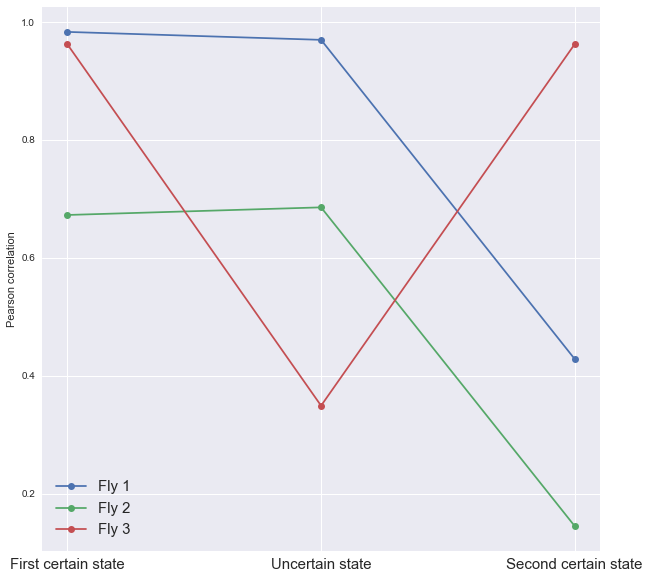

In [10]:
#Plot correlation for each state per fly

plt.plot(abs(np.transpose(dataCorr)),marker="o")
plt.ylabel('Pearson correlation')
#plt.title('Pearson correlation between heading and EPG decoding across states',fontsize=20)
plt.xticks([0,1,2], ['First certain state','Uncertain state','Second certain state'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'],fontsize=15)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\\plots\\allCorr.png", dpi=150)

#This correlation metric seems pretty terrible

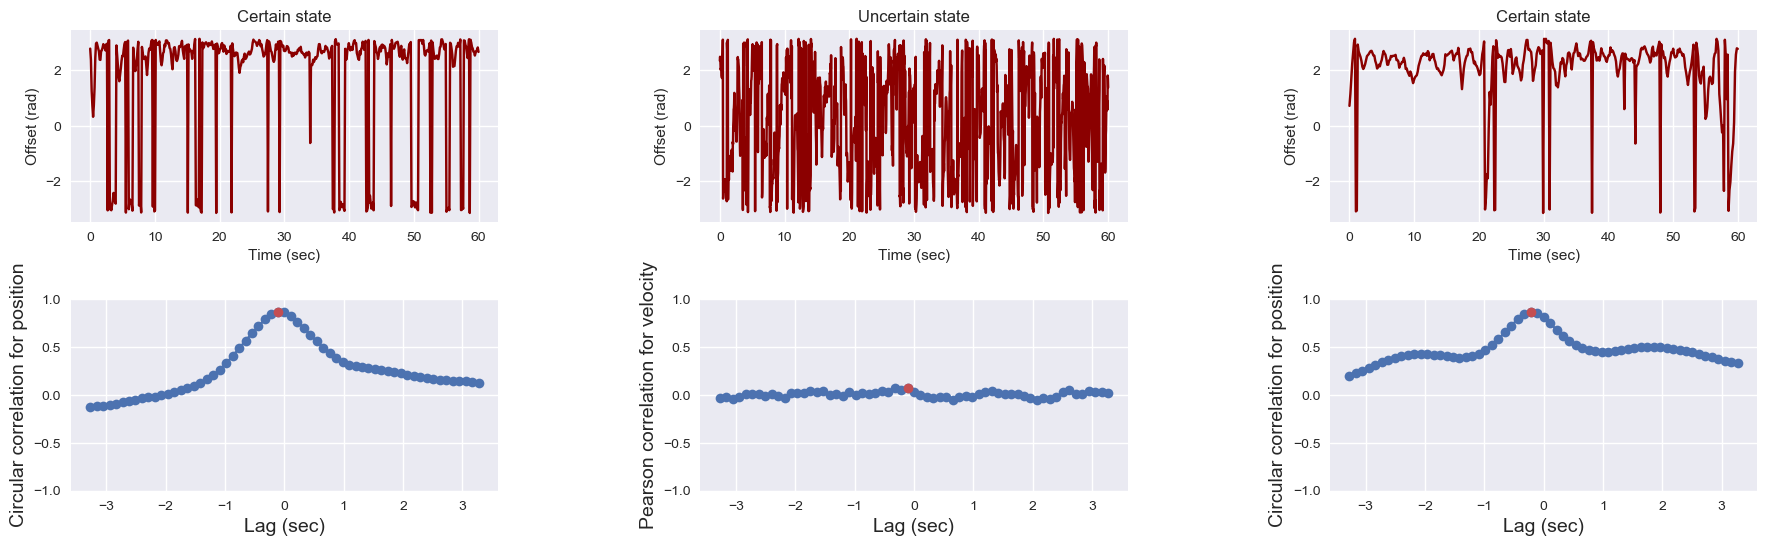

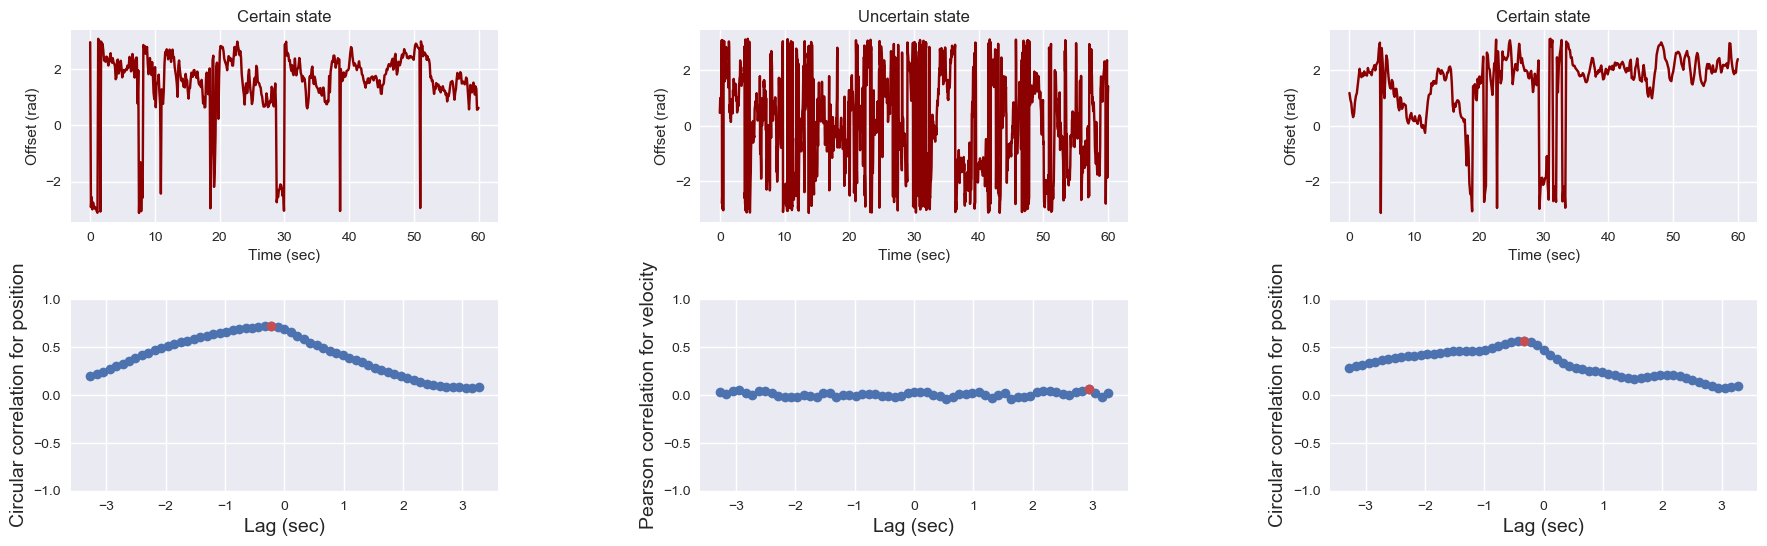

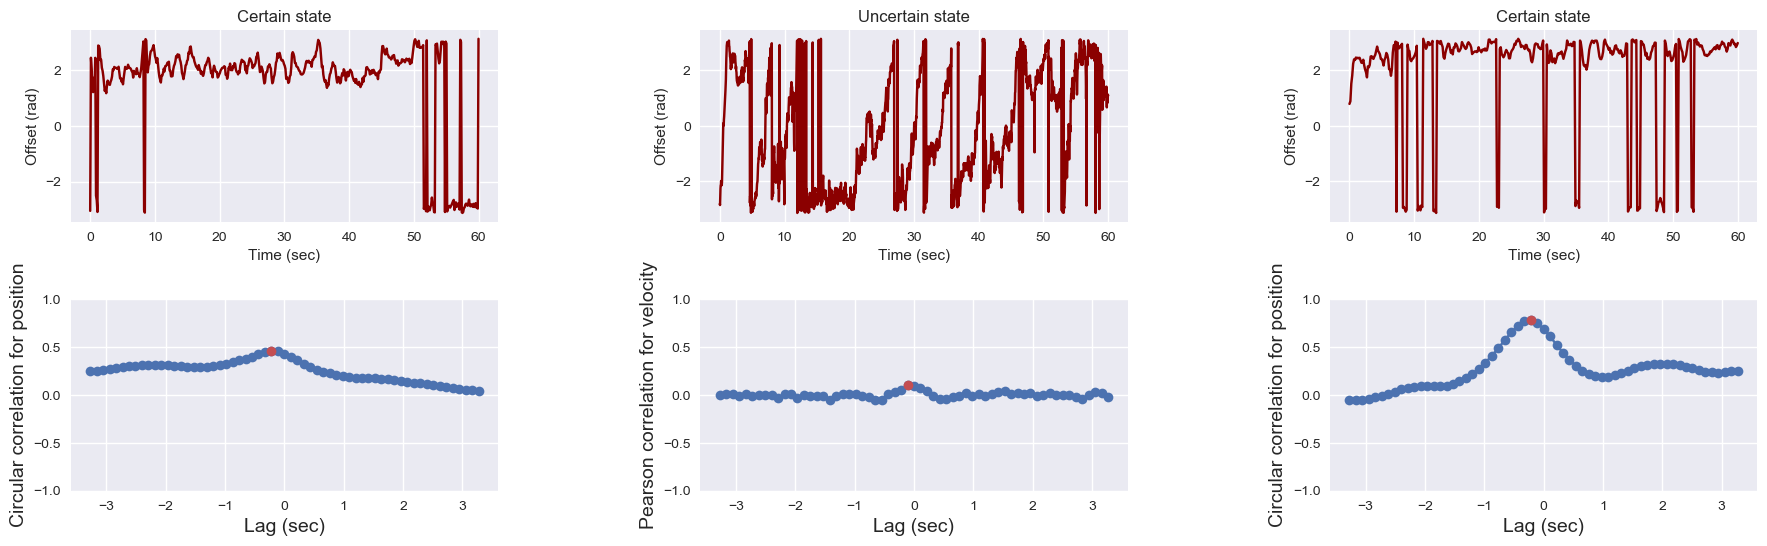

In [11]:
#2) Using the Maimon lab criteria from Green et al 2017

#for closed-loop bar experiments, he computes the circular correlation between the GCaMP phase and bar position.
#for experiments in the dark, he computes the Pearson correlation between GCaMP phase velocity and ball velocity.
#he calculates these correlations for different time lags between the phase and ball signals, and reports the higher correlation.
#for all phase correlations, he only includes data during which the fly is walking with a speed of at least 1 mm/s
#he also requires that the peak activity is greater than 0.8 DF/F to ensure that the phase is properly estimated.


DataCorr = np.zeros((flyNum,3))

for fly in range(flyNum):
    fig, axs = plt.subplots(2,3, figsize = (15, 10), dpi=100)
    
    offset = flyGroupData[0,fly]['offset'][0,0:StartDark]
    axs[0,0].plot(np.linspace(0,60,len(offset)),offset,color='darkred')
    axs[0,0].set(ylabel='Offset (rad)')
    axs[0,0].set(xlabel='Time (sec)')    
    
    actualHeading1 = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,0:StartDark])
    decodedHeading1 = np.unwrap(flyGroupData[0,fly]['phase_value'][0,0:StartDark])    
    #try different lags
    #Initialize a vector of all the possible lags
    lags = np.arange(-30, 31, 1)
    timeLag = lags*(300/2751) #change from ds frames to sec
    circCoef1 = np.zeros((len(lags),1))
    #run a loop for every element in the lags vector
    for lag in lags:
        #circularly shift the decoded heading by that lag
        shiftedDecodHeading1 = np.roll(decodedHeading1,lags[lag])
        #compute the circular correlation and save
        circCoef1[lag] = circcorrcoef(actualHeading1,shiftedDecodHeading1)    
    
    #find the peaks
    peaks, _ = find_peaks(circCoef1[:,0])
    #retain the taller peak
    peakValues = circCoef1[peaks]
    MinToMaxOrder = np.argsort(peakValues, axis=0)
    MaxToMinOrder = np.flip(MinToMaxOrder)
    Peaks = peaks[MaxToMinOrder[0:1]]
    #add to plot
    axs[1,0].plot(timeLag,circCoef1,marker='o')
    axs[1,0].plot(timeLag[Peaks[0,0]], circCoef1[Peaks[0,0],0],'ro')
    axs[1,0].set_ylabel('Circular correlation for position', fontsize=14)
    axs[1,0].set_xlabel('Lag (sec)', fontsize=14)
    axs[1,0].set_ylim(-1,1)
    DataCorr[fly,0] = circCoef1[Peaks[0,0],0]
    
    
    offset = flyGroupData[0,fly]['offset'][0,StartDark:EndDark]
    axs[0,1].plot(np.linspace(0,60,len(offset)),offset,color='darkred')
    axs[0,1].set(ylabel='Offset (rad)')
    axs[0,1].set(xlabel='Time (sec)')    
    
    actualHeading2 = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,StartDark:EndDark])
    decodedHeading2 = np.unwrap(flyGroupData[0,fly]['phase_value'][0,StartDark:EndDark])  
    pearsonCoef2 = np.zeros((len(lags),1))
    #run a loop for every element in the lags vector
    for lag in lags:
        #circularly shift the decoded heading by that lag
        shiftedDecodHeading2 = np.roll(np.ediff1d(decodedHeading2),lags[lag])
        #compute the circular correlation and save
        pearsonCoef2[lag] = pearsonr(np.ediff1d(actualHeading2),shiftedDecodHeading2)[0]
    
    peaks, _ = find_peaks(pearsonCoef2[:,0])
    peakValues = pearsonCoef2[peaks]
    MinToMaxOrder = np.argsort(peakValues, axis=0)
    MaxToMinOrder = np.flip(MinToMaxOrder)
    Peaks = peaks[MaxToMinOrder[0:1]]
    axs[1,1].plot(timeLag,pearsonCoef2,marker='o')
    axs[1,1].plot(timeLag[Peaks[0,0]], pearsonCoef2[Peaks[0,0],0],'ro')
    axs[1,1].set_ylabel('Pearson correlation for velocity', fontsize=14)
    axs[1,1].set_xlabel('Lag (sec)', fontsize=14)
    axs[1,1].set_ylim(-1,1)
    DataCorr[fly,1] = pearsonCoef2[Peaks[0,0],0]
        

    offset = flyGroupData[0,fly]['offset'][0,EndDark:]
    axs[0,2].plot(np.linspace(0,60,len(offset)),offset,color='darkred')
    axs[0,2].set(ylabel='Offset (rad)')
    axs[0,2].set(xlabel='Time (sec)')    
    
    actualHeading3 = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,EndDark:])
    decodedHeading3 = np.unwrap(flyGroupData[0,fly]['phase_value'][0,EndDark:])    
    #try different lags
    #Initialize a vector of all the possible lags
    circCoef3 = np.zeros((len(lags),1))
    #run a loop for every element in the lags vector
    for lag in lags:
        #circularly shift the decoded heading by that lag
        shiftedDecodHeading3 = np.roll(decodedHeading3,lags[lag])
        #compute the circular correlation and save
        circCoef3[lag] = circcorrcoef(actualHeading3,shiftedDecodHeading3)    
    
    peaks, _ = find_peaks(circCoef3[:,0])
    peakValues = circCoef3[peaks]
    MinToMaxOrder = np.argsort(peakValues, axis=0)
    MaxToMinOrder = np.flip(MinToMaxOrder)
    Peaks = peaks[MaxToMinOrder[0:1]]
    axs[1,2].plot(timeLag,circCoef3,marker='o')
    axs[1,2].plot(timeLag[Peaks[0,0]], circCoef3[Peaks[0,0],0],'ro')
    axs[1,2].set_ylabel('Circular correlation for position', fontsize=14)
    axs[1,2].set_xlabel('Lag (sec)', fontsize=14)
    axs[1,2].set_ylim(-1,1)
    DataCorr[fly,2] = circCoef3[Peaks[0,0],0]
        
    axs[0,0].set(title='Certain state')
    axs[0,1].set(title='Uncertain state')
    axs[0,2].set(title='Certain state')
    
    
    fig.tight_layout(pad=5.0)
    plt.gcf().set_size_inches(20, 6)
    plt.savefig(mainDir + "\\plots\individualCorrFlyGreen" + str(fly) + ".png", dpi=150)

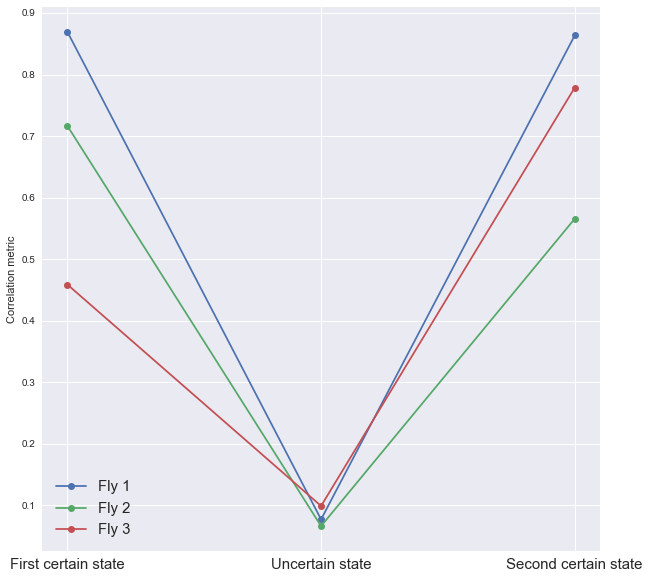

In [12]:
#Plot correlation for each state per fly

plt.plot(abs(np.transpose(DataCorr)),marker="o")
plt.ylabel('Correlation metric')
plt.xticks([0,1,2], ['First certain state','Uncertain state','Second certain state'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'],fontsize=15)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\\plots\\allCorrGreen.png", dpi=150)

#This metric makes a lot more sense!

We are next going to look at bump magnitude. As a first approximation, we will define bump magnitude as the max-min fluorescence for each timepoint. We can average the activity from the left and right PB, averaging the activity of the corresponding glomeruli. To know which glomeruli we averaged, we can look at PB connectivity and see which glomeruli project to the same region of the EB.

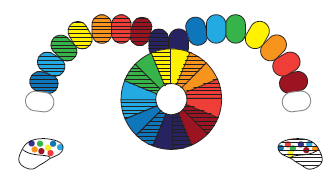

In [13]:
from IPython.display import Image
Image(mainDir + "\\plots\\PBconnectivity.png")

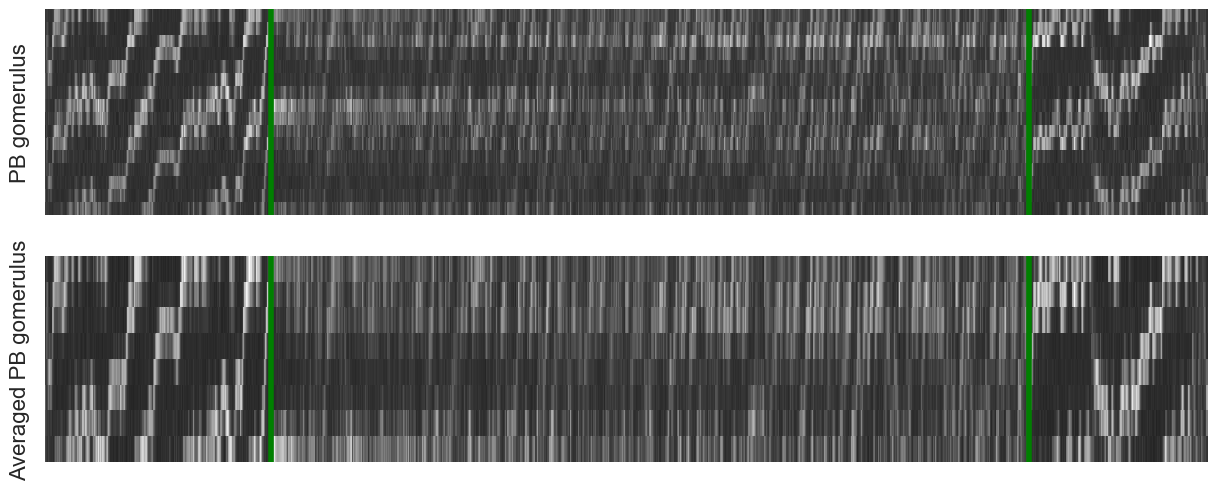

In [14]:
#See what the heatmap with averaged activity looks like
leftPB = [0,1,2,3,4,5,6,7]
rightPB = [9,10,11,12,13,14,15,8]

dff_matrix = flyGroupData[0,0]['dff_matrix']
my_cmap = sns.dark_palette("white", as_cmap=True)
    
fig,(ax1, ax2) = plt.subplots(2,1, figsize = (15, 6), dpi=100)
g = sns.heatmap(dff_matrix,cmap=my_cmap,ax=ax1, cbar=False)
g.set_yticklabels('')
g.set_ylabel('PB gomerulus', fontsize=16)
ax1.axvline(x=StartDark, color='green', lw = 4)
ax1.axvline(x=EndDark, color='green', lw = 4)
plt.setp(ax1.get_xticklabels(), visible=False)

combined_dff = (flyGroupData[0,0]['dff_matrix'][leftPB,:] + flyGroupData[0,0]['dff_matrix'][rightPB,:] )/2
g2 = sns.heatmap(combined_dff,cmap=my_cmap,ax=ax2, cbar=False)
g2.set_yticklabels('')
g2.set_ylabel('Averaged PB gomerulus', fontsize=16)
ax2.axvline(x=StartDark, color='green', lw = 4)
ax2.axvline(x=EndDark, color='green', lw = 4)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.savefig(mainDir + "\\plots\\averagedPBexample.png", dpi=150)

#The averaged activity seems to recapitulate pretty faithfully the activity across the PB

In [15]:
# We will first calculate bump magnitude as max - min DeltaF/F for every frame

def stat_range(x):
    return max(x) - min(x)

#for each fly, calculate range
newData = []
state = []
smoothedData = []
frames = np.shape(flyGroupData[0,0]['dff_matrix'])[1]

for fly in range(flyNum):
        #average the data from the two PB halves
        combined_dff = (flyGroupData[0,fly]['dff_matrix'][leftPB,:] + flyGroupData[0,fly]['dff_matrix'][rightPB,:] )/2
        #newData.append(np.apply_along_axis(stat_range, 0, flyGroupData[0,fly]['dff_matrix']))
        newData.append(np.apply_along_axis(stat_range, 0, combined_dff))        
        state.extend(np.repeat(np.array(1),flyGroupData[0,fly]['StartDarkness'][0,0]))
        state.extend(np.repeat(np.array(2),flyGroupData[0,fly]['EndDarkness'][0,0]-flyGroupData[0,fly]['StartDarkness'][0,0]))
        state.extend(np.repeat(np.array(3),frames-flyGroupData[0,fly]['EndDarkness'][0,0]))
        smoothedData.append(gaussian_filter(newData[fly], sigma=5)) #change sigma for the smoothing window
                
bumpData = np.reshape(np.array(newData),flyNum*len(newData[0]))
smoothedBumpData = np.reshape(np.array(smoothedData),flyNum*len(smoothedData[0]))
flyID = np.repeat(np.array(range(flyNum))+1,frames)
time = [flyData[0,0].time,flyData[0,0].time,flyData[0,0].time]
time = np.reshape(time,frames*3)

# Combine all the data in a dataframe
bumpdata = {'Fly ID': flyID, 'State': state, 'BumpMagMinMax': bumpData, 'Time': time, 'SmoothedBumpMagMinMax': smoothedBumpData}
bumpDF = pd.DataFrame(bumpdata)

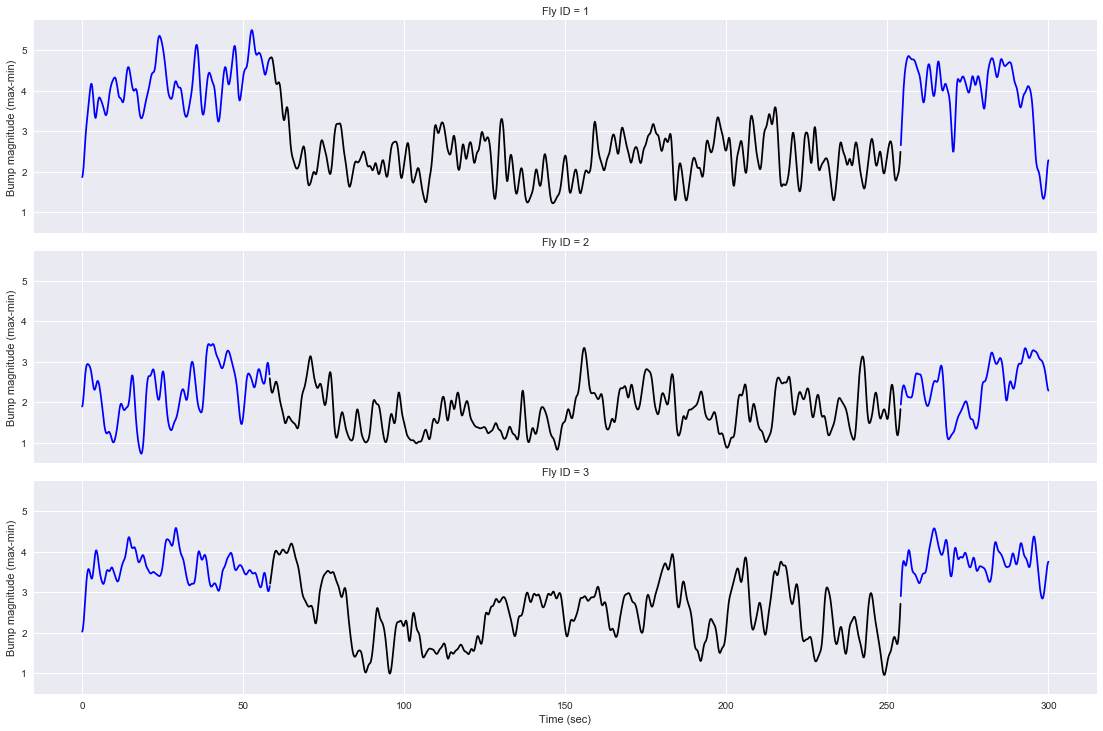

In [16]:
# Plot the bump magnitude in time for max-min

newPalette = sns.color_palette("hls", 3)
newPalette[0] = (0,0,1)
newPalette[1] = (0,0,0)
newPalette[2] = newPalette[0]

g = sns.relplot("Time", "SmoothedBumpMagMinMax", data=bumpDF, row='Fly ID', hue = 'State', kind="line" ,palette=newPalette)
g._legend.remove()
g.set(xlabel='Time (sec)', ylabel='Bump magnitude (max-min)')
plt.gcf().set_size_inches(20, 10)
plt.savefig(mainDir + "\plots\BumpMagPy.png", dpi=150)

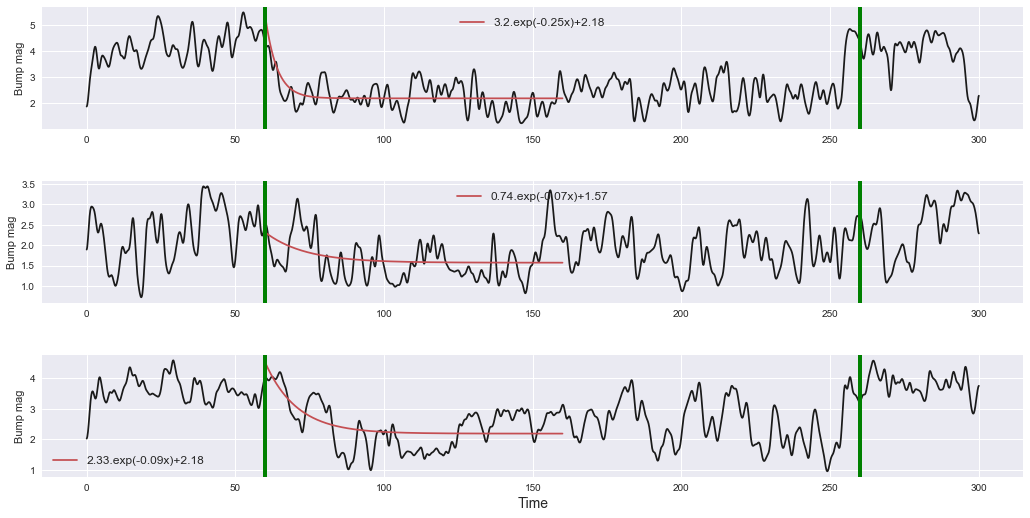

In [17]:
#Fitting an exponential decay to the bump magnitude once the panels are turned off

def expFit(x, a, b, c):
    return a * np.exp(-b * x) + c

fig, axs = plt.subplots(3,1, figsize=(15, 8))
    
for fly in range(flyNum):
    totalTime = np.linspace(0, 300, frames)
    startFit = 60 #panels turning on in sec
    fitWindow = 100 #length of fit window in sec
    endFit = startFit + fitWindow
    fitTime = np.linspace(0, endFit-startFit,round(endFit*(2751/300))-534)
    popt, pcov = curve_fit(expFit, fitTime, smoothedData[fly][534:round(endFit*(2751/300))])
    axs[fly].plot(totalTime, smoothedData[fly], 'k',label=None)
    axs[fly].plot(fitTime + 60, expFit(fitTime, *popt), 'r-',label = str(round(popt[0],2))+'.exp(-'+str(round(popt[1],2))+'x)+' + str(round(popt[2],2)))
    axs[fly].axvline(x=60, color='green', lw = 4)
    axs[fly].axvline(x=260, color='green', lw = 4) 
    axs[fly].set_ylabel('Bump mag')
    plt.xlabel('Time',fontsize=14) 
    fig.tight_layout(pad=3.0)
    axs[fly].legend( prop={'size': 12})
    
plt.savefig(mainDir + "\plots\BumpMagInTimeFit.png", dpi=150)

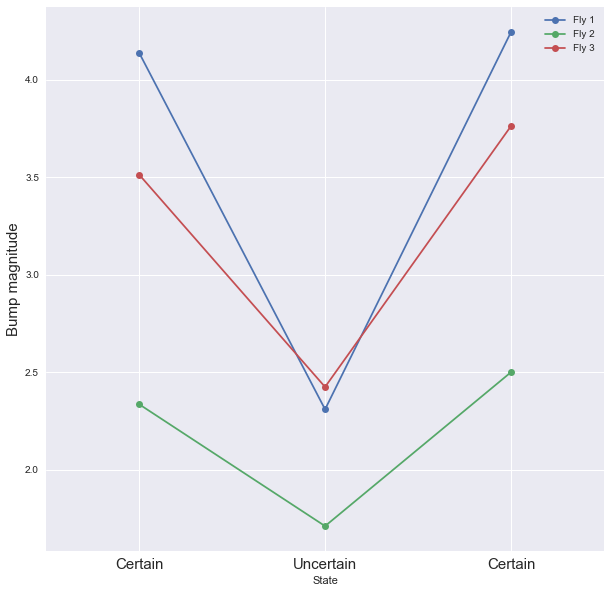

In [18]:
# Calculate and plot median bump magnitude for each state

medianBump = bumpDF.groupby(['State','Fly ID'])[['BumpMagMinMax']].median()
bumpDF.groupby(['State','Fly ID'])[['BumpMagMinMax']].median().unstack().plot(marker="o")
plt.ylabel('Bump magnitude',fontsize=15)
plt.xticks([1,2,3], ['Certain','Uncertain','Certain'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'])
plt.xlim(0.5,3.5)
plt.gcf().set_size_inches(10, 10)
#plt.title('Median bump magnitude across states',fontsize=20)
plt.savefig(mainDir + "\plots\BumpMagAcrossStatesPy.png", dpi=150)


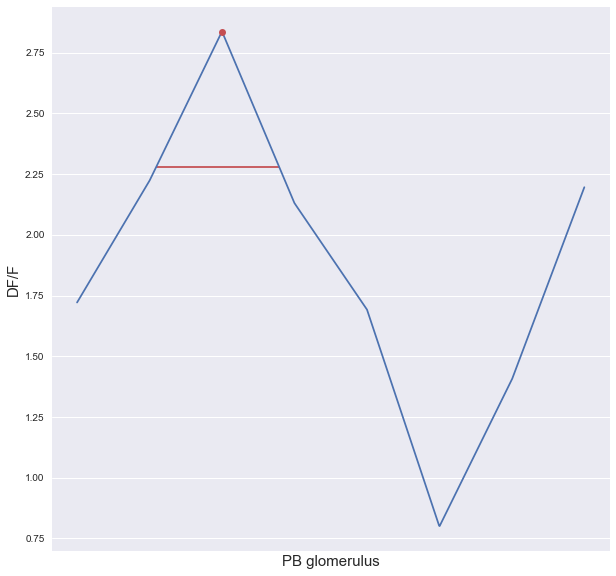

In [19]:
#Calculate bump width at half max for 1 example timepoint and plot.

exampleData = np.interp(np.linspace(0,7,1000),range(8),combined_dff[:,3])
#find the peaks
peaks, _ = find_peaks(exampleData)
#retain the taller 2 peaks (2 bumps)
peakValues = exampleData[peaks]
MinToMaxOrder = np.argsort(peakValues)
MaxToMinOrder = np.flip(MinToMaxOrder)
Peaks = peaks[MaxToMinOrder[0:2]]
#plot
results_half = peak_widths(exampleData, Peaks, rel_height=0.5)
plt.plot(exampleData)
plt.xlabel('PB glomerulus',fontsize=15)
plt.ylabel('DF/F',fontsize=15)
plt.xticks(ticks=[], labels=[])
plt.plot(peaks, exampleData[peaks], "ro")
plt.hlines(*results_half[1:], color="C2")
plt.gcf().set_size_inches(10, 10)
#plt.title('Example data for one frame',fontsize = 20)
plt.savefig(mainDir + "\plots\ExampleBumpWidthAtHalfMax.png", dpi=150)

#save the data and average both widths
allHalfWidths = results_half[0]
meanHalfWidth = np.mean(allHalfWidths)*8/1000

In [20]:
# Calculate the width at half max for every frame for every fly

interpData = np.zeros((1000,1))
half_width = np.zeros((flyNum,frames))

for fly in range(flyNum):
    combined_dff = (flyGroupData[0,fly]['dff_matrix'][leftPB,:] + flyGroupData[0,fly]['dff_matrix'][rightPB,:] )/2
    for frame in range(frames):
        interpData = np.interp(np.linspace(0,7,1000),range(8),combined_dff[:,frame])
        peaks, _ = find_peaks(interpData)
        if (peaks.size != 0):
            peakValues = interpData[peaks]
            MinToMaxOrder = np.argsort(peakValues)
            MaxToMinOrder = np.flip(MinToMaxOrder)
            Peaks = peaks[MaxToMinOrder[0:1]]
            results_half = peak_widths(interpData, Peaks, rel_height=0.5)
            half_width[fly,frame] = results_half[0][0]
        else:
            half_width[fly,frame] = None #if the algorithm detected no peaks, I'm setting the corresponding cell to have no data, although I'm not sure if this is the best way to go about things


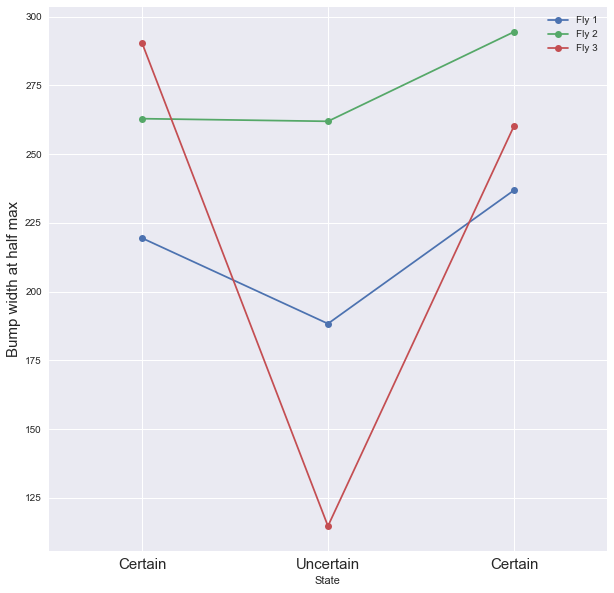

In [21]:
# Get the median width at half max for each fly and each state and plot

HalfWidthMax = np.reshape(half_width,3*frames)
bumpDF['HalfWidthMax'] = HalfWidthMax

bumpDF.groupby(['State','Fly ID'])[['HalfWidthMax']].median().unstack().plot(marker="o")
plt.ylabel('Bump width at half max', fontsize=15)
plt.xticks([1,2,3], ['Certain','Uncertain','Certain'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'])
plt.xlim(0.5,3.5)
#plt.title('Median bump width at half max across states', fontsize=20)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\plots\BumpWidthAtHalfMaxPy.png", dpi=150)
#add errorbars

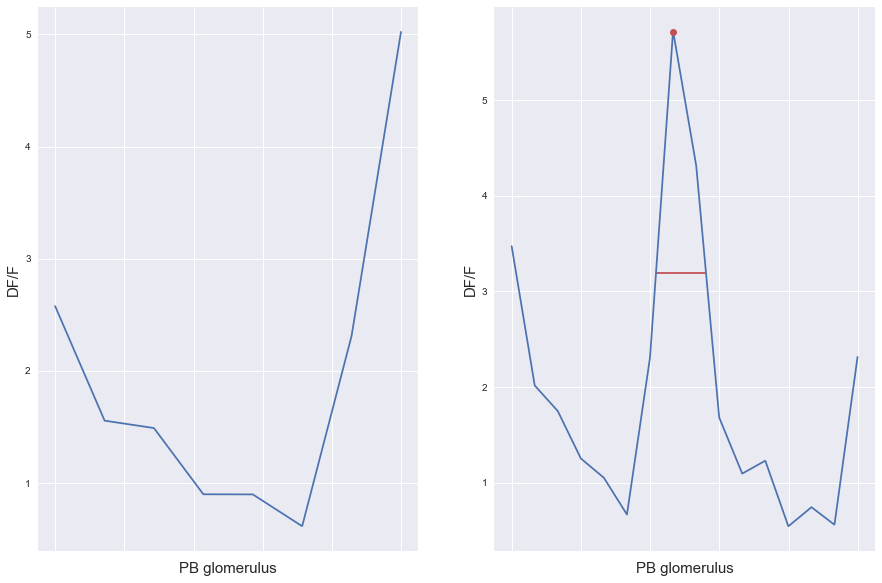

In [22]:
#This trend seems very strange. There are points in which the algorithm fails to find peaks. Let's explore one of those time points closer to see what's going on

######################### averaging the 2 PB halves
combined_dff = (flyGroupData[0,2]['dff_matrix'][leftPB,:] + flyGroupData[0,2]['dff_matrix'][rightPB,:] )/2
exampleData = np.interp(np.linspace(0,7,1000),range(8),combined_dff[:,12])

#find the peaks
peaks, _ = find_peaks(exampleData)
#retain the taller 2 peaks (2 bumps)
peakValues = exampleData[peaks]
MinToMaxOrder = np.argsort(peakValues)
MaxToMinOrder = np.flip(MinToMaxOrder)
Peaks = peaks[MaxToMinOrder[0:1]] #retain the taller
#plot
results_half = peak_widths(exampleData, Peaks, rel_height=0.5)

fig, axs = plt.subplots(1,2, figsize=(15, 6))
axs[0].plot(exampleData)
axs[0].set_xlabel('PB glomerulus',fontsize=15)
axs[0].set_ylabel('DF/F',fontsize=15)
axs[0].set_xticklabels([])
axs[0].plot(Peaks, exampleData[Peaks], 'x')
axs[0].hlines(*results_half[1:], color="C2")

###################### looking at all the PB
exampleData = np.interp(np.linspace(0,15,1000),range(16),flyGroupData[0,2]['dff_matrix'][:,12])
#find the peaks
peaks, _ = find_peaks(exampleData)
#retain the taller 2 peaks (2 bumps)
peakValues = exampleData[peaks]
MinToMaxOrder = np.argsort(peakValues)
MaxToMinOrder = np.flip(MinToMaxOrder)
Peaks = peaks[MaxToMinOrder[0:1]]
#plot
results_half = peak_widths(exampleData, Peaks, rel_height=0.5)

axs[1].plot(exampleData)
axs[1].set_xlabel('PB glomerulus',fontsize=15)
axs[1].set_ylabel('DF/F',fontsize=15)
axs[1].set_xticklabels([])
axs[1].plot(Peaks, exampleData[Peaks], "ro")
axs[1].hlines(*results_half[1:], color="C2")

plt.gcf().set_size_inches(15, 10)
plt.savefig(mainDir + "\plots\DualExampleBumpWidthAtHalfMax.png", dpi=150)


Given the possibility that we might we losing the bump signal in many timepoints using this metric, we are going to resort to using the full 16 PN glomeruli, then finding the two taller peaks (which might be just 1 for certain instances), find the width at half max for those peaks, and average them.

In [23]:
# Calculate the width at half max for every frame for every fly

interpData = np.zeros((1000,1))
half_width = np.zeros((flyNum,frames))

for fly in range(flyNum):
    for frame in range(frames):
        interpData = np.interp(np.linspace(0,15,1000),range(16),flyGroupData[0,fly]['dff_matrix'][:,frame])
        peaks, _ = find_peaks(interpData)
        if (peaks.size != 0):
            peakValues = interpData[peaks]
            MinToMaxOrder = np.argsort(peakValues)
            MaxToMinOrder = np.flip(MinToMaxOrder)
            Peaks = peaks[MaxToMinOrder[0:2]]
            results_half = peak_widths(interpData, Peaks, rel_height=0.5)
            half_width[fly,frame] = np.mean(results_half[0])
        else:
            half_width[fly,frame] = None #if the algorithm detected no peaks, I'm setting the corresponding cell to have no data, although I'm not sure if this is the best way to go about things
            

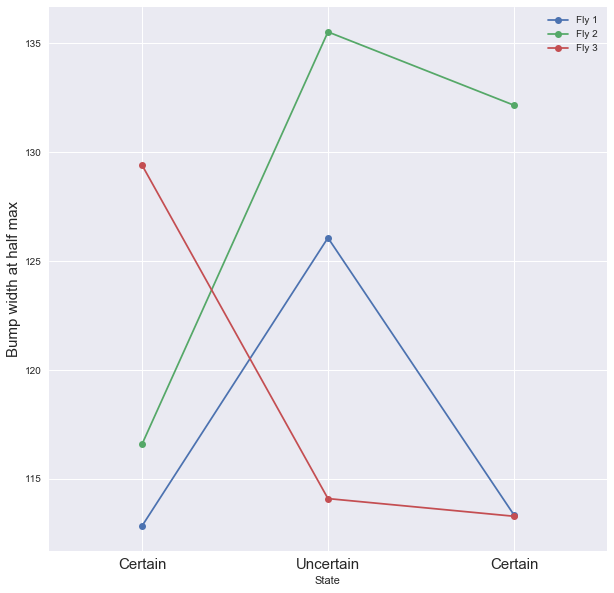

In [24]:
HalfWidthMaxAllG = np.reshape(half_width,3*frames)
bumpDF['HalfWidthMaxAllG'] = HalfWidthMaxAllG

bumpDF.groupby(['State','Fly ID'])[['HalfWidthMaxAllG']].median().unstack().plot(marker="o")
plt.ylabel('Bump width at half max', fontsize=15)
plt.xticks([1,2,3], ['Certain','Uncertain','Certain'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'])
plt.xlim(0.5,3.5)
#plt.title('Median bump width at half max across states', fontsize=20)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\plots\BumpWidthAtHalfMaxAllG.png", dpi=150)

This does not seem to work very well. We are next going to get both the bump magnitude and the bump width using a von Mises fit.

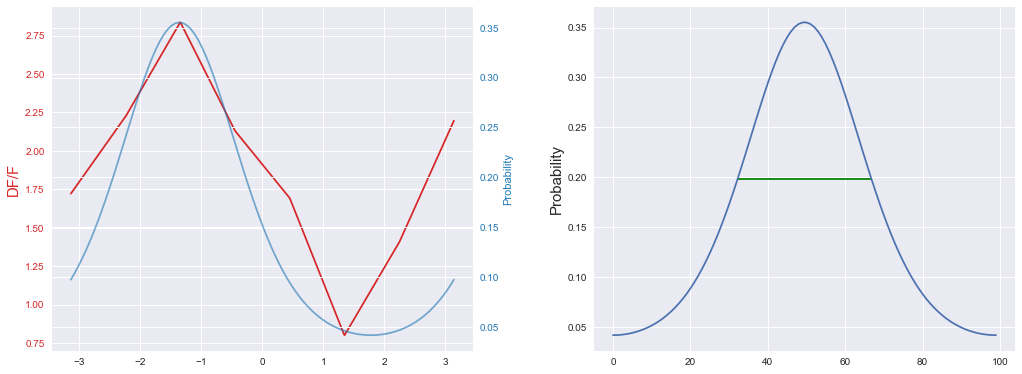

In [25]:
#Let's start by trying the fit with an individual time point, for a given fly. We will use the same timepoint that we used for the other method

combined_dff = (flyGroupData[0,2]['dff_matrix'][leftPB,:] + flyGroupData[0,2]['dff_matrix'][rightPB,:] )/2
exampleData2 = np.interp(np.linspace(0,7,1000),range(8),combined_dff[:,3])
param = vonmises.fit(exampleData2)
fig, (ax1,ax3) = plt.subplots(1,2, figsize=(15, 6))
color = 'tab:red'
ax1.plot(np.linspace(-np.pi,np.pi,1000),exampleData2, color=color)
ax1.set_ylabel('DF/F',fontsize=15, color=color)
#ax1.set_xlabel('Heading angle',fontsize=15)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_xticks(ticks=[], labels=[])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
x = np.linspace(vonmises.ppf(0.000000001, param[0]),vonmises.ppf(0.999999999,param[0]), 100)

fitData = vonmises.pdf(x, param[0], -0.55*param[1])
ax2.plot(x, fitData, alpha=0.6, color=color)
ax2.set_ylabel('Probability', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

# Let's now find the width at half max for this datapoint
#find the peaks
fitData = vonmises.pdf(x, param[0]) #to find the width at half max, I'll only use k, since u will shift the plot and might crop the peak on the sides, leading to a lower estimate of the width at half max than reality.
peaks, _ = find_peaks(fitData)
#retain the taller peak (1 bump)
peakValues = fitData[peaks]
MinToMaxOrder = np.argsort(peakValues)
MaxToMinOrder = np.flip(MinToMaxOrder)
Peaks = peaks[MaxToMinOrder[0:1]]
#get the width at half max
results_half = peak_widths(fitData, Peaks, rel_height=0.5)
#plot
ax3.plot(fitData)
ax3.set_ylabel('Probability',fontsize=15)
ax3.set_xticklabels=[]
ax3.plot(peaks, fitData[peaks], "x")
ax3.hlines(*results_half[1:], color="green")

fig.tight_layout(pad=3.0)
plt.savefig(mainDir + "\plots\pointFit.png", dpi=150)

In [24]:
#Now let's do the fit for all the data and plot the results

half_width = np.zeros((flyNum,frames))
bump_mag = np.zeros((flyNum,frames))
combined_full_dff = np.zeros((8,frames))
extendedData = np.zeros((1000,frames))
Params = np.zeros((1,1000))
x = np.zeros((1,100))
fitData = np.zeros((1,100))

for fly in range(flyNum):
    dff_matrix = flyGroupData[0,fly]['dff_matrix']
    combined_full_dff = (dff_matrix[leftPB,:] + dff_matrix[rightPB,:])/2
    
    #Add a progress bar
    for i in tqdm(range(frames), position=0):             
        extendedData = np.interp(np.linspace(1,7,1000),range(8),combined_full_dff[:,i])
        Params = vonmises.fit(extendedData)
        bump_mag[fly,i] = Params[0]
        x = np.linspace(vonmises.ppf(0.00001, Params[0]),vonmises.ppf(0.99999,Params[0]), 100)
        fitData = vonmises.pdf(x, Params[0]) 
        peaks, _ = find_peaks(fitData)
        peakValues = fitData[peaks]
        MinToMaxOrder = np.argsort(peakValues)
        MaxToMinOrder = np.flip(MinToMaxOrder)
        Peaks = peaks[MaxToMinOrder[0:1]]
        results_half = peak_widths(fitData, Peaks, rel_height=0.5)
        half_width[fly,i] = results_half[0]
        time.sleep(0.01)
 

100%|██████████████████████████████████████████████████████████████████████████████| 2751/2751 [57:05<00:00,  1.25s/it]


Timer unit: 1e-07 s

Total time: 10657.3 s
File: <ipython-input-24-15304bff8d8c>
Function: von_mises_function at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def von_mises_function():
    14         4        162.0     40.5      0.0      for fly in range(flyNum):
    15         3        292.0     97.3      0.0          dff_matrix = flyGroupData[0,fly]['dff_matrix']
    16         3      10637.0   3545.7      0.0          combined_full_dff = (dff_matrix[leftPB,:] + dff_matrix[rightPB,:])/2
    17                                               
    18                                                   #Add a progress bar
    19      8256  119329453.0  14453.7      0.1          for i in tqdm(range(frames), position=0): 
    20                                                   #for i in range(frames):             
    21      8253   24882980.0   3015.0      0.0              extendedData = np.interp(np.linspace(1,7,100

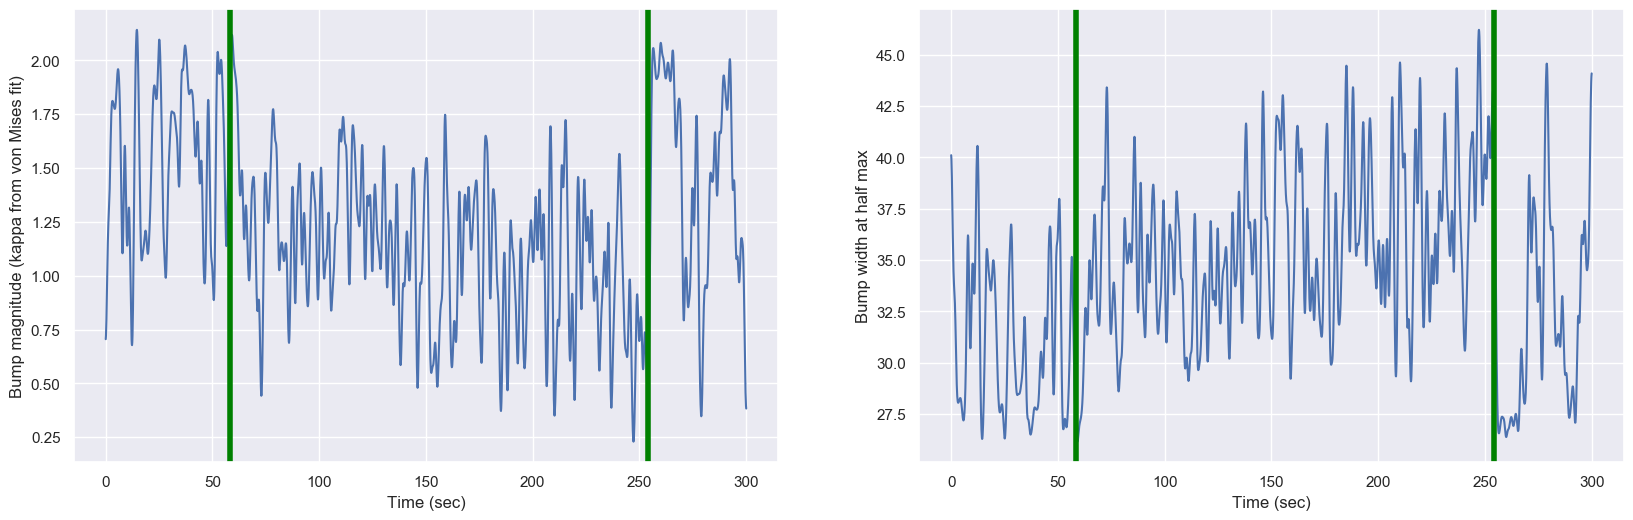

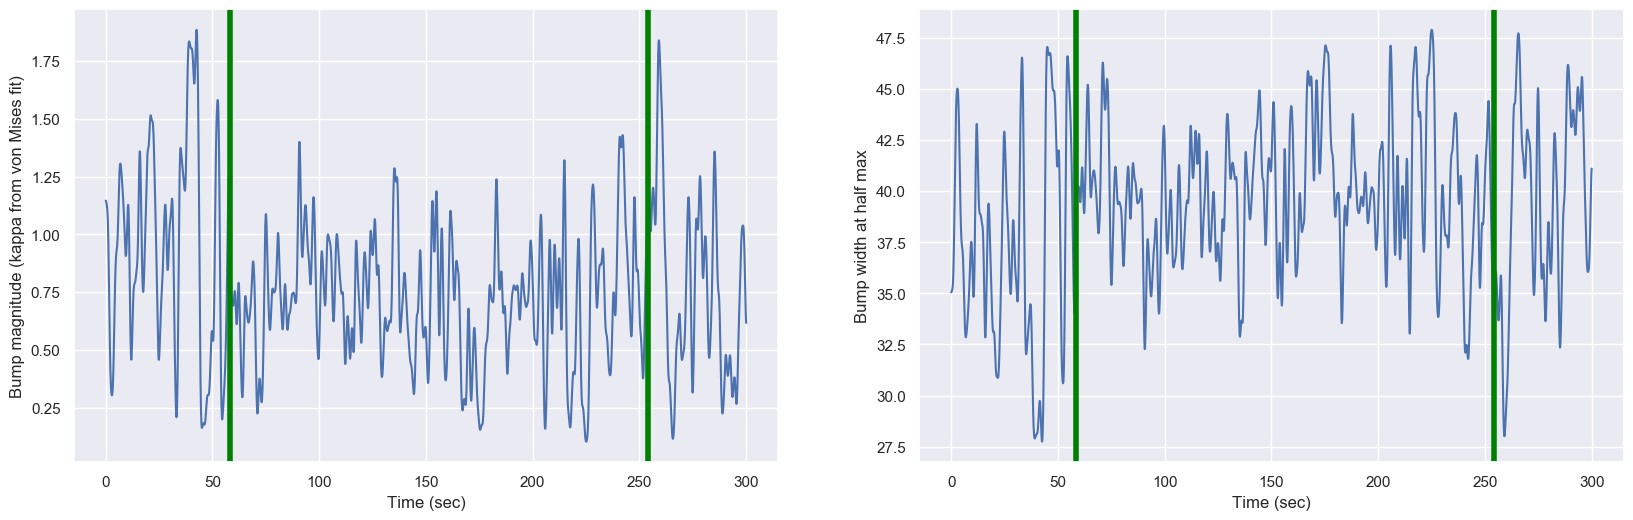

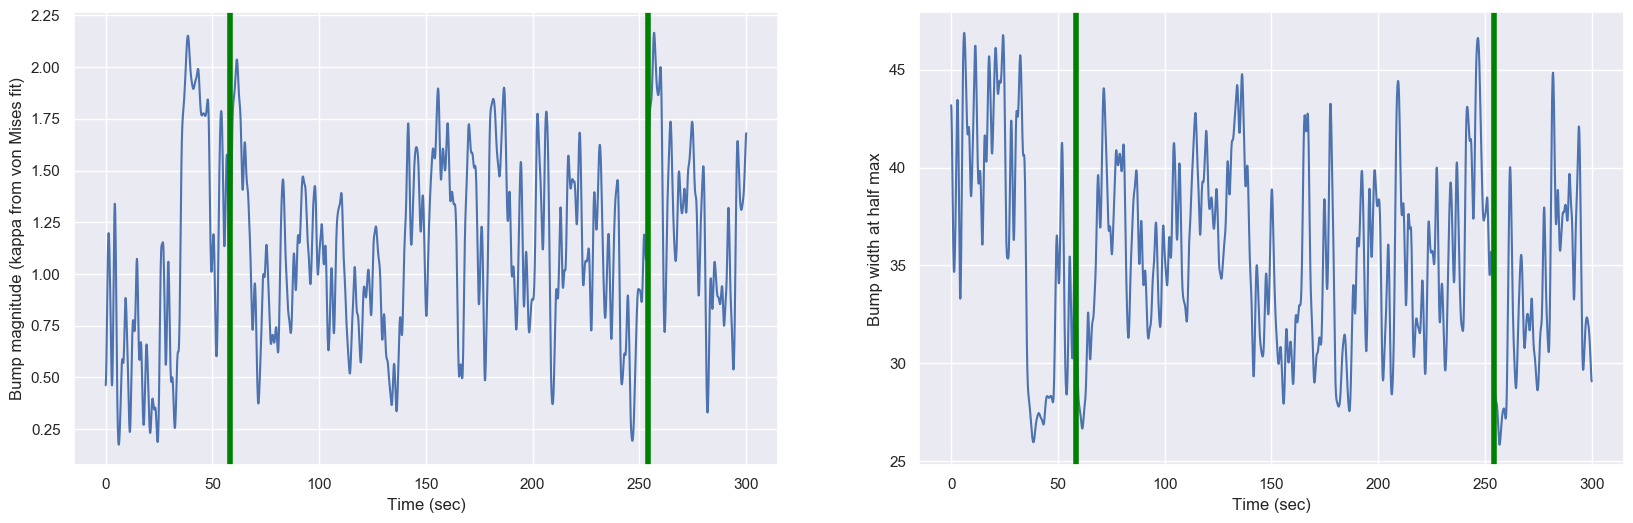

In [78]:
#Let's plot the bump magnitude and width at half max in time to see what we get

secTime = np.linspace(0,300,frames)

for fly in range(len(flyGroupData[0])):
    StartDark = flyGroupData[0,fly]['StartDarkness']
    EndDark = flyGroupData[0,fly]['EndDarkness']
    
    fig, axs = plt.subplots(1,2, figsize = (20, 6), dpi=100)

    smoothed_bump_mag = gaussian_filter(bump_mag[fly,:].transpose(), sigma=5)
    axs[0].plot(secTime,smoothed_bump_mag)
    axs[0].set_ylabel('Bump magnitude (kappa from von Mises fit)')
    axs[0].set_xlabel('Time (sec)')
    axs[0].axvline(x=secTime[round(StartDark[0,0])], color='green', lw = 4)
    axs[0].axvline(x=secTime[round(EndDark[0,0])], color='green', lw = 4)

    smoothed_half_width = gaussian_filter(half_width[fly,:].transpose(), sigma=5)
    axs[1].plot(secTime,smoothed_half_width)
    axs[1].set_ylabel('Bump width at half max')
    axs[1].set_xlabel('Time (sec)')
    axs[1].axvline(x=secTime[round(StartDark[0,0])], color='green', lw = 4)
    axs[1].axvline(x=secTime[round(EndDark[0,0])], color='green', lw = 4)

    plt.savefig(mainDir + "\plots\\dataFitFly" + str(fly) + ".png", dpi=150)

In [28]:
#Getting the median bump mag and width at half max for each fly for each state

newBMData = []
state = []
smoothedBMData = []

for fly in range(flyNum):
        newBMData.append(bump_mag[fly,:])
        state.extend(np.repeat(np.array(1),flyGroupData[0,fly]['StartDarkness'][0,0]))
        state.extend(np.repeat(np.array(2),flyGroupData[0,fly]['EndDarkness'][0,0]-flyGroupData[0,fly]['StartDarkness'][0,0]))
        state.extend(np.repeat(np.array(3),frames-flyGroupData[0,fly]['EndDarkness'][0,0]))
        smoothedBMData.append(gaussian_filter(newBMData[fly], sigma=5)) #change sigma for the smoothing window
                
bumpData = np.reshape(np.array(newBMData),flyNum*len(newBMData[0]))
smoothedBumpData = np.reshape(np.array(smoothedBMData),flyNum*len(smoothedBMData[0]))
flyID = np.repeat(np.array(range(flyNum))+1,frames)

# Combine all the data in a dataframe
bumpdata = {'Fly ID': flyID, 'State': state, 'BumpMag': bumpData, 'SmoothedBumpMag': smoothedBumpData}
bumpDF = pd.DataFrame(bumpdata)

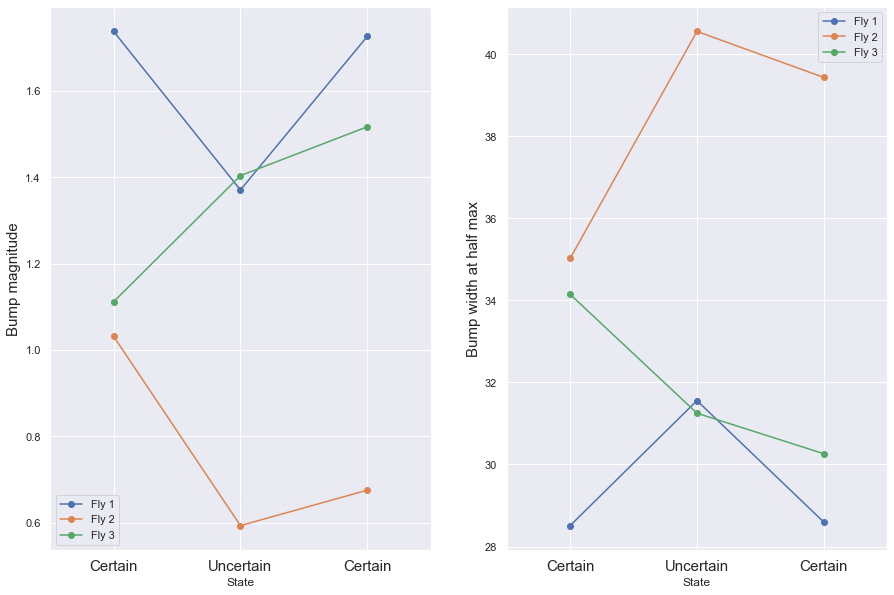

In [59]:
#Plot median bump mag and width obtained with the von Mises fit

medianBump = bumpDF.groupby(['State','Fly ID'])[['BumpMag']].median()

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

bumpDF.groupby(['State','Fly ID'])[['BumpMag']].median().unstack().plot(marker="o", ax=ax1)
ax1.set_ylabel('Bump magnitude',fontsize=15)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['Certain','Uncertain','Certain'],fontsize=15)
ax1.legend(['Fly 1', 'Fly 2', 'Fly 3'])
ax1.set_xlim(0.5,3.5)

HalfWidthMax = np.reshape(half_width,3*frames)
bumpDF['HalfWidthMax'] = HalfWidthMax

bumpDF.groupby(['State','Fly ID'])[['HalfWidthMax']].median().unstack().plot(marker="o", ax=ax2)
ax2.set_ylabel('Bump width at half max', fontsize=15)
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(['Certain','Uncertain','Certain'],fontsize=15)
ax2.legend(['Fly 1', 'Fly 2', 'Fly 3'])
ax2.set_xlim(0.5,3.5)

plt.gcf().set_size_inches(15, 10)
plt.savefig(mainDir + "\plots\medianFitValues.png", dpi=150)

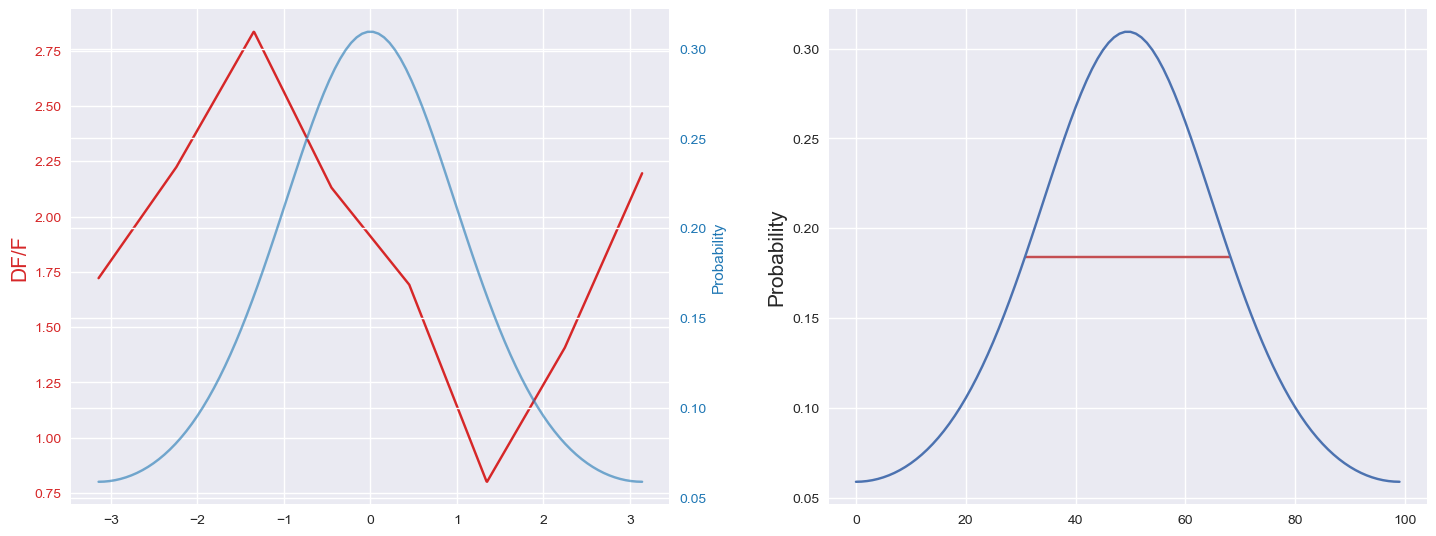

In [31]:
#The trend for fly 3 appears weird given her heatmap. We are now going to apply some pre-processing that Yvette used when fitting her data with von Mises distributions. Let's turn back to the example datapoint again.

combined_dff = (flyGroupData[0,2]['dff_matrix'][leftPB,:] + flyGroupData[0,2]['dff_matrix'][rightPB,:] )/2
exampleData2 = np.interp(np.linspace(0,7,1000),range(8),combined_dff[:,3])

dataMin = min(exampleData2);
#min subtract
dataMinSubtract  = exampleData2 - dataMin;
dataMaxAfterMinSubtract = max(dataMinSubtract);
# max divide
normData = dataMinSubtract / dataMaxAfterMinSubtract;

param = vonmises.fit(normData)
fig, (ax1,ax3) = plt.subplots(1,2, figsize=(15, 6))
color = 'tab:red'
ax1.plot(np.linspace(-np.pi,np.pi,1000),exampleData2, color=color)
ax1.set_ylabel('DF/F',fontsize=15, color=color)
#ax1.set_xlabel('Heading angle',fontsize=15)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_xticks(ticks=[], labels=[])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
x = np.linspace(vonmises.ppf(0.000000001, param[0]),vonmises.ppf(0.999999999,param[0]), 100)
#x = np.linspace(-np.pi,np.pi,1000)
fitData = vonmises.pdf(x, param[0], -1.8*param[1])
#fitData = vonmises.pdf(x, param[0], -param[1])
ax2.plot(x, fitData, alpha=0.6, color=color)
ax2.set_ylabel('Probability', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

# Let's now find the width at half max for this datapoint
#find the peaks
fitData = vonmises.pdf(x, param[0]) #to find the width at half max, I'll only use k, since u will shift the plot and might crop the peak on the sides, leading to a lower estimate of the width at half max than reality.
peaks, _ = find_peaks(fitData)
#retain the taller peak (1 bump)
peakValues = fitData[peaks]
MinToMaxOrder = np.argsort(peakValues)
MaxToMinOrder = np.flip(MinToMaxOrder)
Peaks = peaks[MaxToMinOrder[0:1]]
#get the width at half max
results_half = peak_widths(fitData, Peaks, rel_height=0.5)
#plot
ax3.plot(fitData)
ax3.set_ylabel('Probability',fontsize=15)
ax3.set_xticklabels=[]
ax3.plot(peaks, fitData[peaks], "x")
ax3.hlines(*results_half[1:], color="C2")

fig.tight_layout(pad=3.0)
#plt.savefig(mainDir + "\plots\pointFitPreProcessed.png", dpi=150)


In [205]:
#It looks pretty similar to the previous one, but let's repeat it for every time point and see what we get

#Now let's do the fit for all the data and plot the results

half_width = np.zeros((flyNum,frames))
bump_mag = np.zeros((flyNum,frames))
combined_full_dff = np.zeros((8,frames))
extendedData = np.zeros((1000,frames))
Params = np.zeros((1,1000))
x = np.zeros((1,100))
fitData = np.zeros((1,100))

for fly in range(flyNum):
    dff_matrix = flyGroupData[0,fly]['dff_matrix']
    combined_full_dff = (dff_matrix[leftPB,:] + dff_matrix[rightPB,:])/2
    
    #Add a progress bar
    for i in tqdm(range(frames), position=0):             
        extendedData = np.interp(np.linspace(1,7,1000),range(8),combined_full_dff[:,i])       
        dataMin = min(extendedData);
        dataMinSubtract  = extendedData - dataMin;
        dataMaxAfterMinSubtract = max(dataMinSubtract);
        normData = dataMinSubtract / dataMaxAfterMinSubtract;       
        Params = vonmises.fit(normData)
        bump_mag[fly,i] = Params[0]
        x = np.linspace(vonmises.ppf(0.00001, Params[0]),vonmises.ppf(0.99999,Params[0]), 100)
        fitData = vonmises.pdf(x, Params[0]) 
        peaks, _ = find_peaks(fitData)
        peakValues = fitData[peaks]
        MinToMaxOrder = np.argsort(peakValues)
        MaxToMinOrder = np.flip(MinToMaxOrder)
        Peaks = peaks[MaxToMinOrder[0:1]]
        results_half = peak_widths(fitData, Peaks, rel_height=0.5)
        half_width[fly,i] = results_half[0]
        #time.sleep(0.01)


100%|██████████████████████████████████████████████████████████████████████████████| 2751/2751 [38:53<00:00,  1.18it/s]


In [208]:
#Getting the median bump mag and width at half max for each fly for each state

newBMDataPP = []
smoothedBMDataPP = []

for fly in range(flyNum):
        newBMDataPP.append(bump_mag[fly,:])
        smoothedBMDataPP.append(gaussian_filter(newBMDataPP[fly], sigma=5)) #change sigma for the smoothing window
                
bumpDataPP = np.reshape(np.array(newBMDataPP),flyNum*len(newBMDataPP[0]))
smoothedBumpDataPP = np.reshape(np.array(smoothedBMDataPP),flyNum*len(smoothedBMDataPP[0]))

# Add to data frame
bumpDF['bumpMagPP'] = bumpDataPP
bumpDF['bumpMagPPSmoothed'] = smoothedBumpDataPP
HalfWidthMaxPP = np.reshape(half_width,3*frames)
bumpDF['HalfWidthMaxPP'] = HalfWidthMaxPP

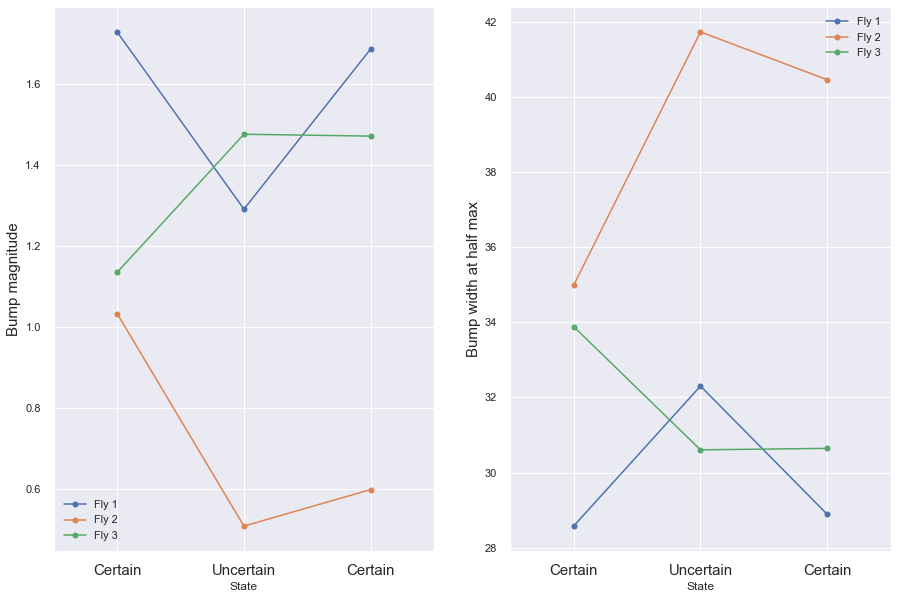

In [212]:
#Plot median bump mag and width obtained with the von Mises fit

medianBump = bumpDF.groupby(['State','Fly ID'])[['bumpMagPP']].median()

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

bumpDF.groupby(['State','Fly ID'])[['bumpMagPP']].median().unstack().plot(marker="o", ax=ax1)
ax1.set_ylabel('Bump magnitude',fontsize=15)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['Certain','Uncertain','Certain'],fontsize=15)
ax1.legend(['Fly 1', 'Fly 2', 'Fly 3'])
ax1.set_xlim(0.5,3.5)

HalfWidthMax = np.reshape(half_width,3*frames)
bumpDF['HalfWidthMax'] = HalfWidthMax

bumpDF.groupby(['State','Fly ID'])[['HalfWidthMaxPP']].median().unstack().plot(marker="o", ax=ax2)
ax2.set_ylabel('Bump width at half max', fontsize=15)
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(['Certain','Uncertain','Certain'],fontsize=15)
ax2.legend(['Fly 1', 'Fly 2', 'Fly 3'])
ax2.set_xlim(0.5,3.5)

plt.gcf().set_size_inches(15, 10)
plt.savefig(mainDir + "\plots\medianFitValuesYvette.png", dpi=150)


In [26]:
#I believe that the results that I got wit the von Mises fit have something wrong. I'm going to import the data that I obtained from doing the fit in MATLAB

os.chdir(mainDir + '\data\\') #move inside of the folder, inside the dark trial folder
fitdata = sio.loadmat('fitdata.mat', struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
fit_bump_mag = fitdata['bump_mag'] 
fit_half_width = fitdata['half_width'] 

In [27]:
#Let's now add it to the data frame

# Add to data frame
bumpDF['bumpMagFit'] = np.transpose(fit_bump_mag)
bumpDF['bumpHWFit'] = np.transpose(fit_half_width)


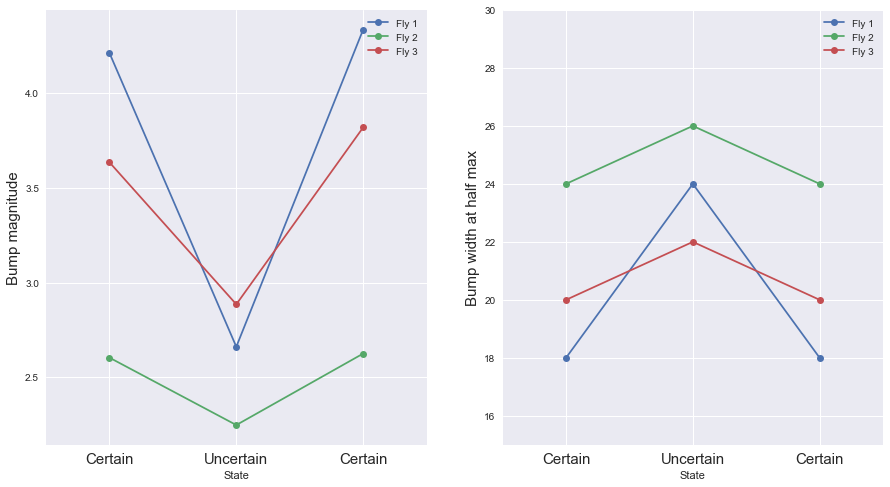

In [28]:
#Plot the median data

plt.style.use('seaborn')

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

bumpDF.groupby(['State','Fly ID'])[['bumpMagFit']].median().unstack().plot(marker="o", ax=ax1)
ax1.set_ylabel('Bump magnitude',fontsize=15)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['Certain','Uncertain','Certain'],fontsize=15)
ax1.legend(['Fly 1', 'Fly 2', 'Fly 3'])
ax1.set_xlim(0.5,3.5)

bumpDF.groupby(['State','Fly ID'])[['bumpHWFit']].median().unstack().plot(marker="o", ax=ax2)
ax2.set_ylabel('Bump width at half max', fontsize=15)
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(['Certain','Uncertain','Certain'],fontsize=15)
ax2.legend(['Fly 1', 'Fly 2', 'Fly 3'])
ax2.set_xlim(0.5,3.5)
ax2.set_ylim(15,30)

plt.gcf().set_size_inches(15, 8)
plt.savefig(mainDir + "\plots\medianFitValuesMatlab.png", dpi=150)

#This looks much more reasonable! We will keep using this data
bumpMagFit = bumpDF['bumpMagFit']

In [29]:
# We are going to now store the animal's angular speed data

flyAngSpeed = []

for fly in range(flyNum):
        flyAngSpeed.extend(abs(flyGroupData[0,fly]['ang_vel'][0:np.asscalar(flyGroupData[0,fly]['StartDarkness'])]))
        flyAngSpeed.extend(abs(flyGroupData[0,fly]['ang_vel'][np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])]))
        flyAngSpeed.extend(abs(flyGroupData[0,fly]['ang_vel'][np.asscalar(flyGroupData[0,fly]['EndDarkness']-1):-1]))

bumpDF['flyAngSpeed'] = np.rad2deg(flyAngSpeed)
angSpeed = bumpDF['flyAngSpeed']

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


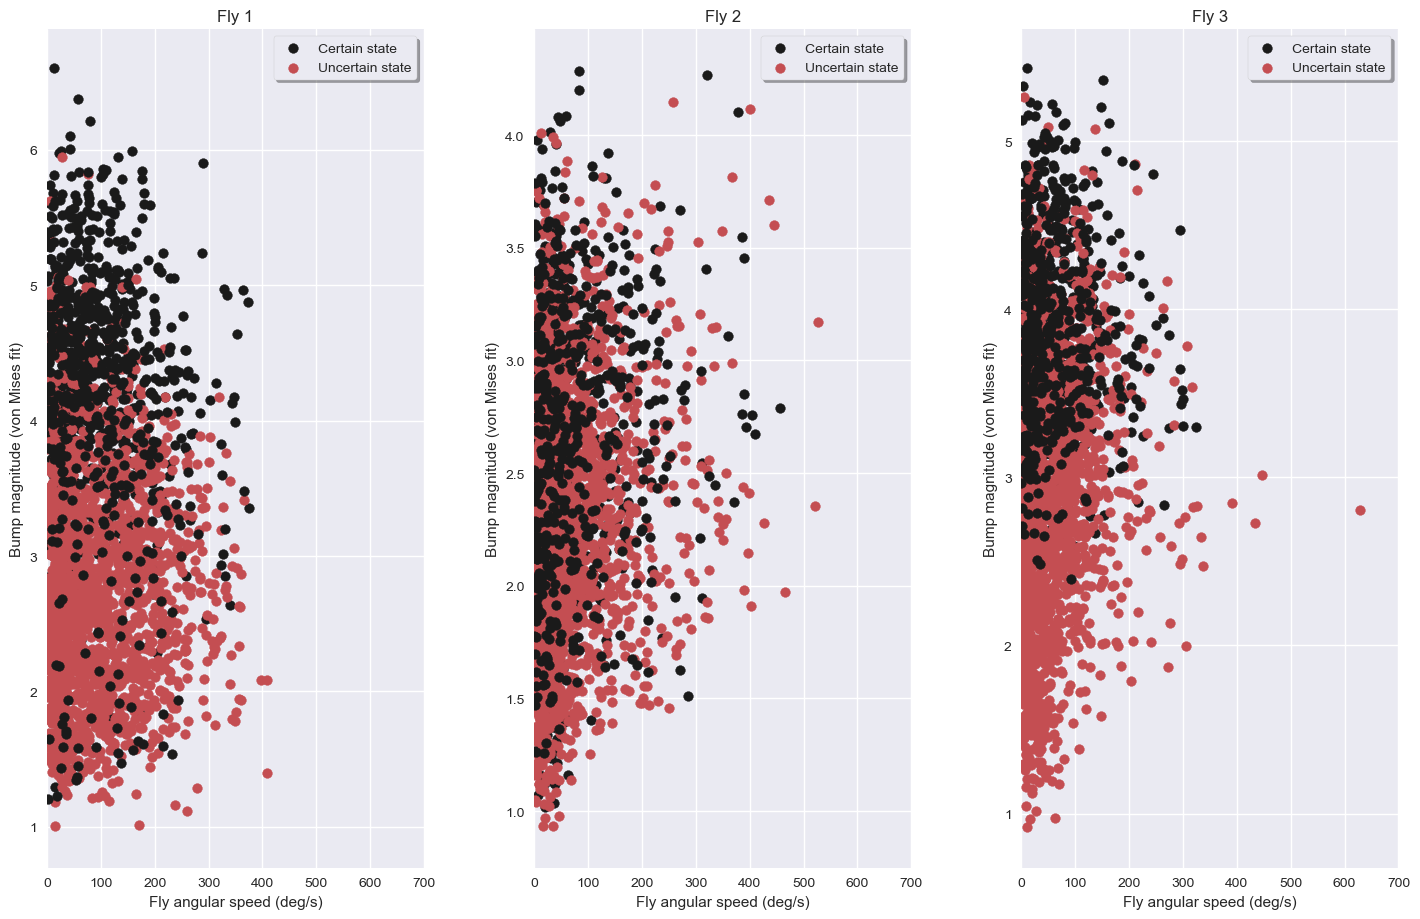

In [30]:
#Let's plot the changes in bump magnitude with respect to changes in angular speed and see if there is an apparent relationship

fig = plt.figure(figsize = (15, 10), dpi=100)
for fly in range(flyNum):
    ax = fig.add_subplot(1, 3, fly+1)
    ax.scatter(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)],bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)] ,c='k')
    ax.scatter(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)],bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,c='r')
    ax.scatter(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)],bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)] ,c='k')  
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump magnitude (von Mises fit)')
    plt.title('Fly ' + str(fly+1))
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')
    ax.set_xlim([0,700])

    fig.tight_layout(pad=3.0)
    
plt.savefig(mainDir + "\plots\BumpMagVsAngSpeed.png", dpi=150)

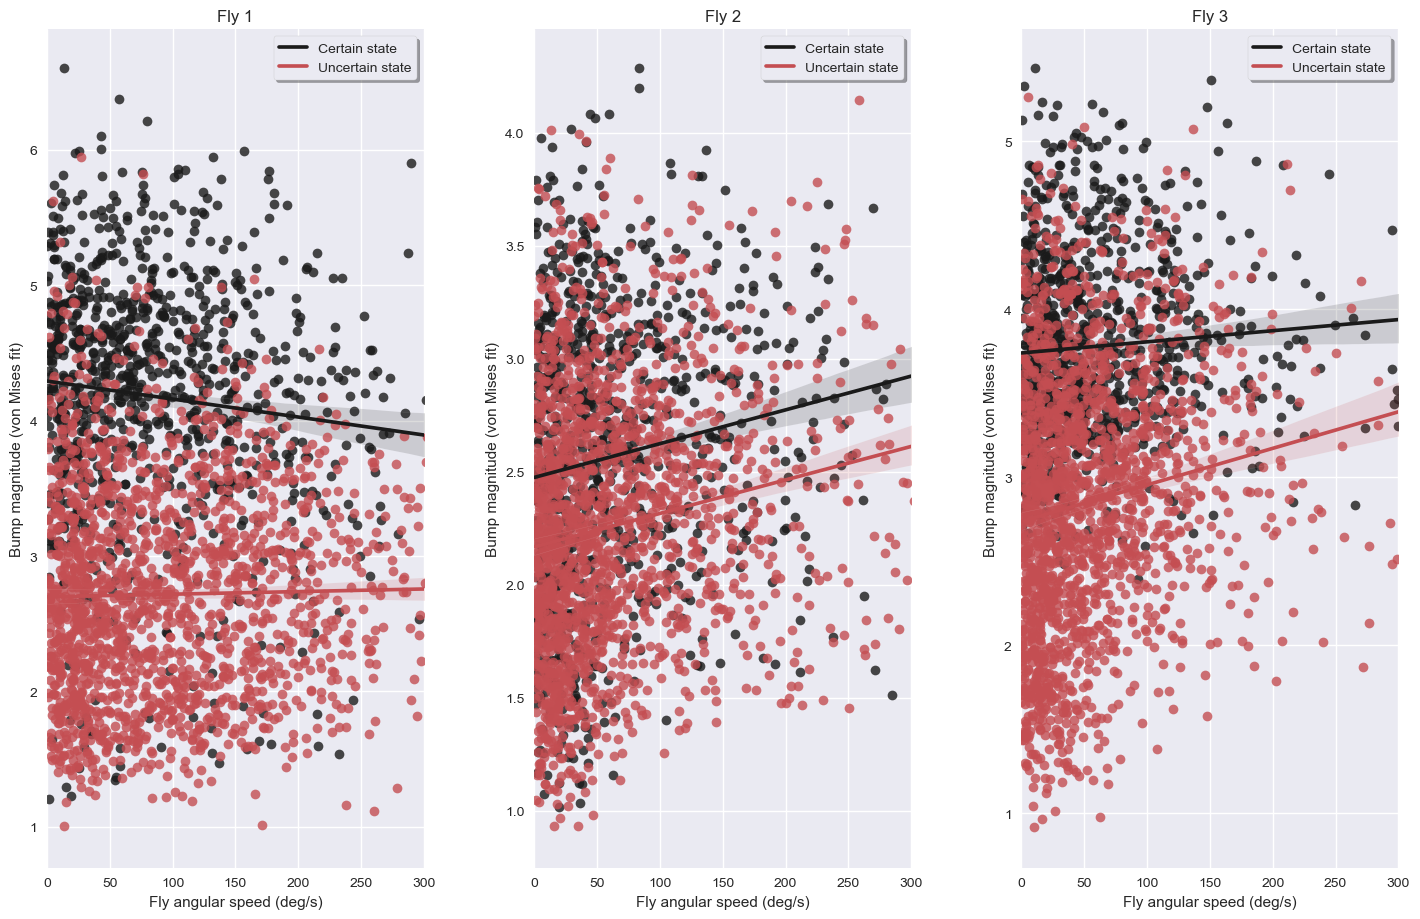

In [31]:
#Adding a regression to the data

fig = plt.figure(figsize = (15, 10), dpi=100)
for fly in range(flyNum):
    ax = fig.add_subplot(1, 3, fly+1)
    ax = sns.regplot(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] != 2)],bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] != 2)] ,color='k')
    ax = sns.regplot(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)],bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,color='r')
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump magnitude (von Mises fit)')
    plt.title('Fly ' + str(fly+1))
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')
    ax.set_xlim([0,300])

    fig.tight_layout(pad=3.0)

In [32]:
 # Bin the data

    ##I have to figure out how to bin the bump magnitude data using the velocity

In [33]:
#For now, let's import the binned data from matlab

os.chdir(mainDir + '\data\\') #move inside of the folder, inside the dark trial folder
binnedData = sio.loadmat('binnedData.mat', struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
medianCertain = binnedData['medianCertainBin'] 
medianUncertain = binnedData['medianUncertainBin'] 
steCertain = binnedData['steCertainBin'] 
steUncertain = binnedData['steUncertainBin'] 


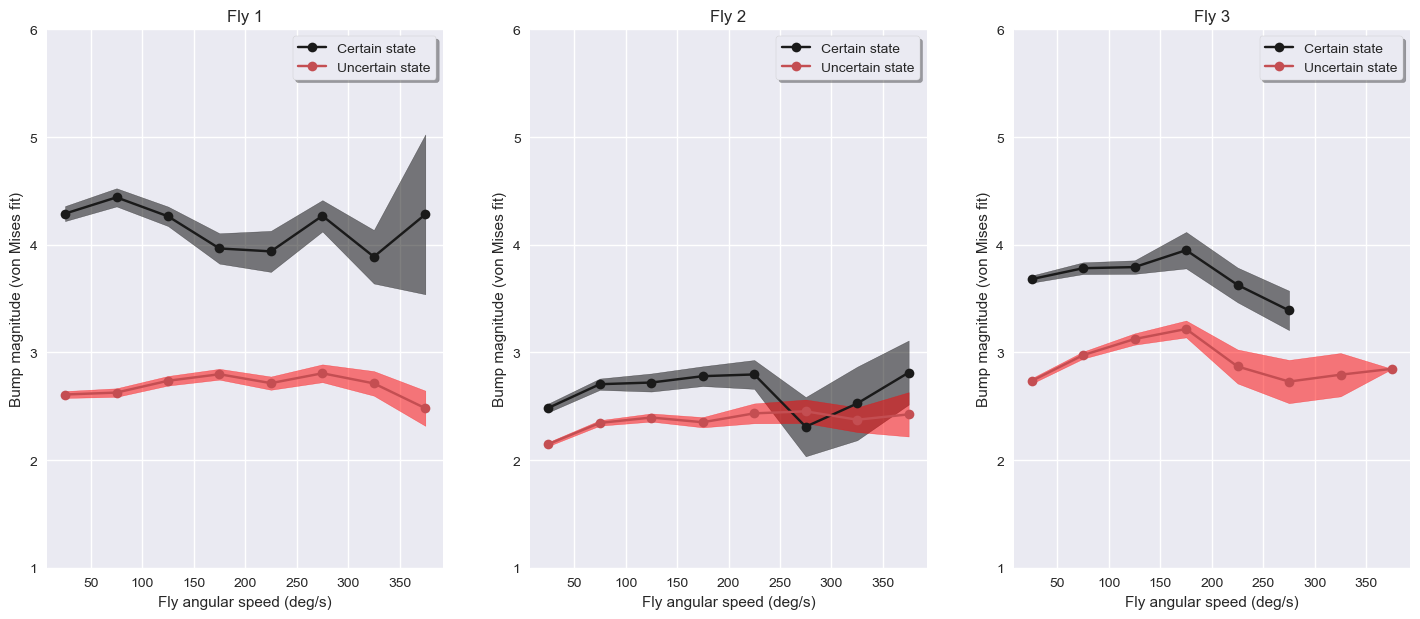

In [34]:
# Let's plot it

velBins = [25,75,125,175,225,275,325,375]

fig = plt.figure(figsize = (15, 7), dpi=100)

for fly in range(flyNum):
    ax = fig.add_subplot(1, flyNum, fly+1)
    ax.plot(velBins, np.squeeze(medianCertain[0,fly]), 'ko-')
    ax.fill_between(velBins, np.squeeze(medianCertain[0,fly])-np.squeeze(steCertain[0,fly]), np.squeeze(medianCertain[0,fly])+np.squeeze(steCertain[0,fly]),color='black',alpha=0.5)
    ax.plot(velBins, np.squeeze(medianUncertain[0,fly]), 'ro-')
    ax.fill_between(velBins, np.squeeze(medianUncertain[0,fly])-np.squeeze(steUncertain[0,fly]), np.squeeze(medianUncertain[0,fly])+np.squeeze(steUncertain[0,fly]),color='red',alpha=0.5)    
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump magnitude (von Mises fit)')
    plt.title('Fly ' + str(fly+1))
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')
    ax.set_ylim([1,6])

fig.tight_layout(pad=3.0)

plt.savefig(mainDir + "\plots\BinnedBumpMagVsAngSpeed.png", dpi=150)

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


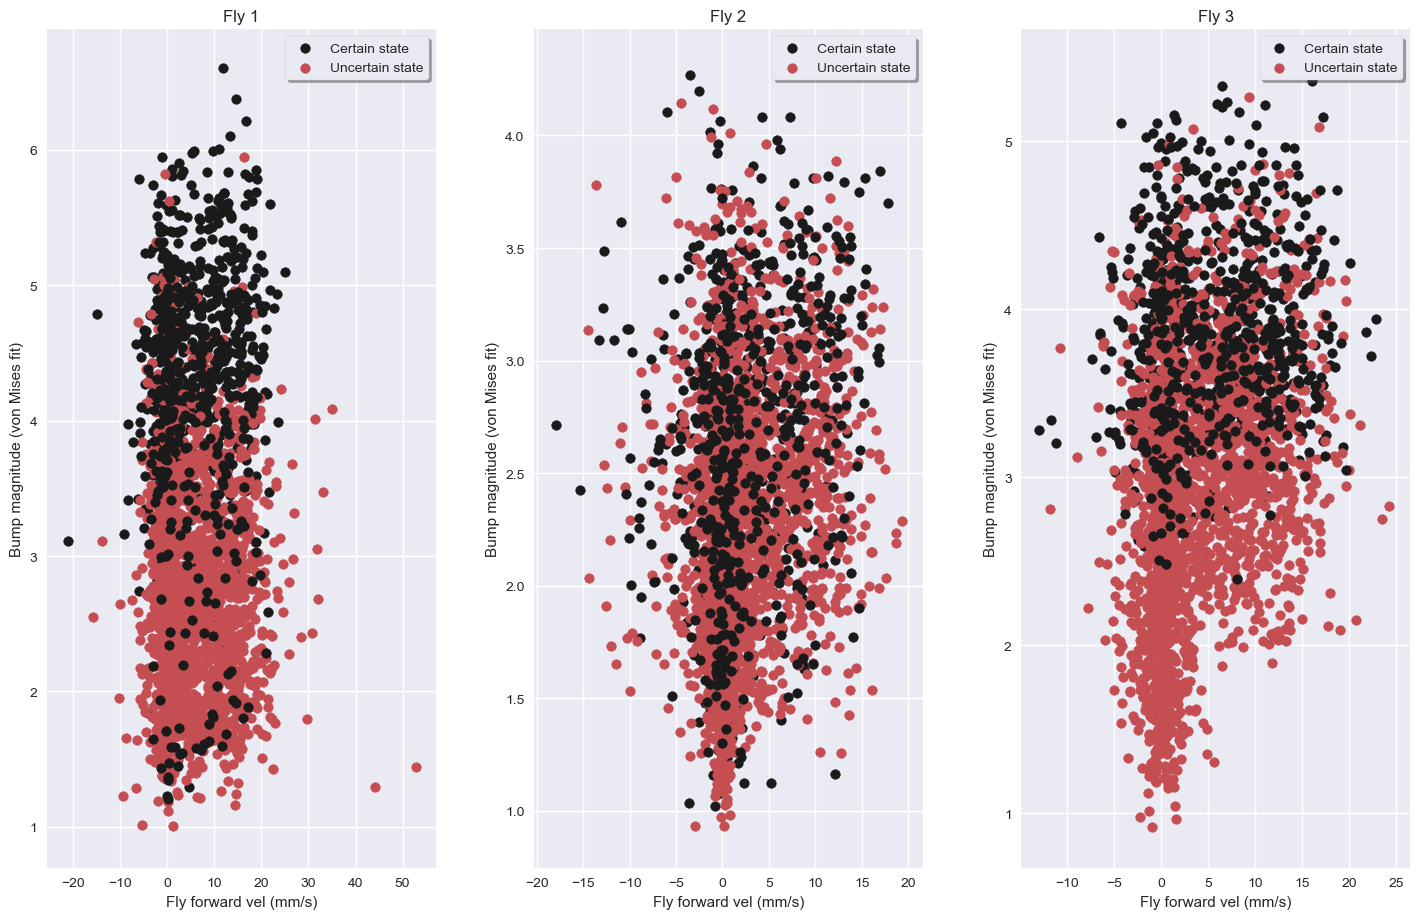

In [33]:
# Scatter of bump magnitude vs fly forward velocity

fig = plt.figure(figsize = (15, 10), dpi=100)
for fly in range(flyNum):
    ax = fig.add_subplot(1, 3, fly+1)
    ax.scatter(4.5*(flyGroupData[0,fly]['for_vel'][0:np.asscalar(flyGroupData[0,fly]['StartDarkness'])]),bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)] ,c='k')
    ax.scatter(4.5*(flyGroupData[0,fly]['for_vel'][np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])]),bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,c='r')
    ax.scatter(4.5*(flyGroupData[0,fly]['for_vel'][np.asscalar(flyGroupData[0,fly]['EndDarkness']):]),bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)] ,c='k')  
    plt.xlabel('Fly forward vel (mm/s)')
    plt.ylabel('Bump magnitude (von Mises fit)')
    plt.title('Fly ' + str(fly+1))
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')

fig.tight_layout(pad=3.0)
plt.savefig(mainDir + "\plots\BumpMagVsFlyFwdVelPy.png", dpi=150)


C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users

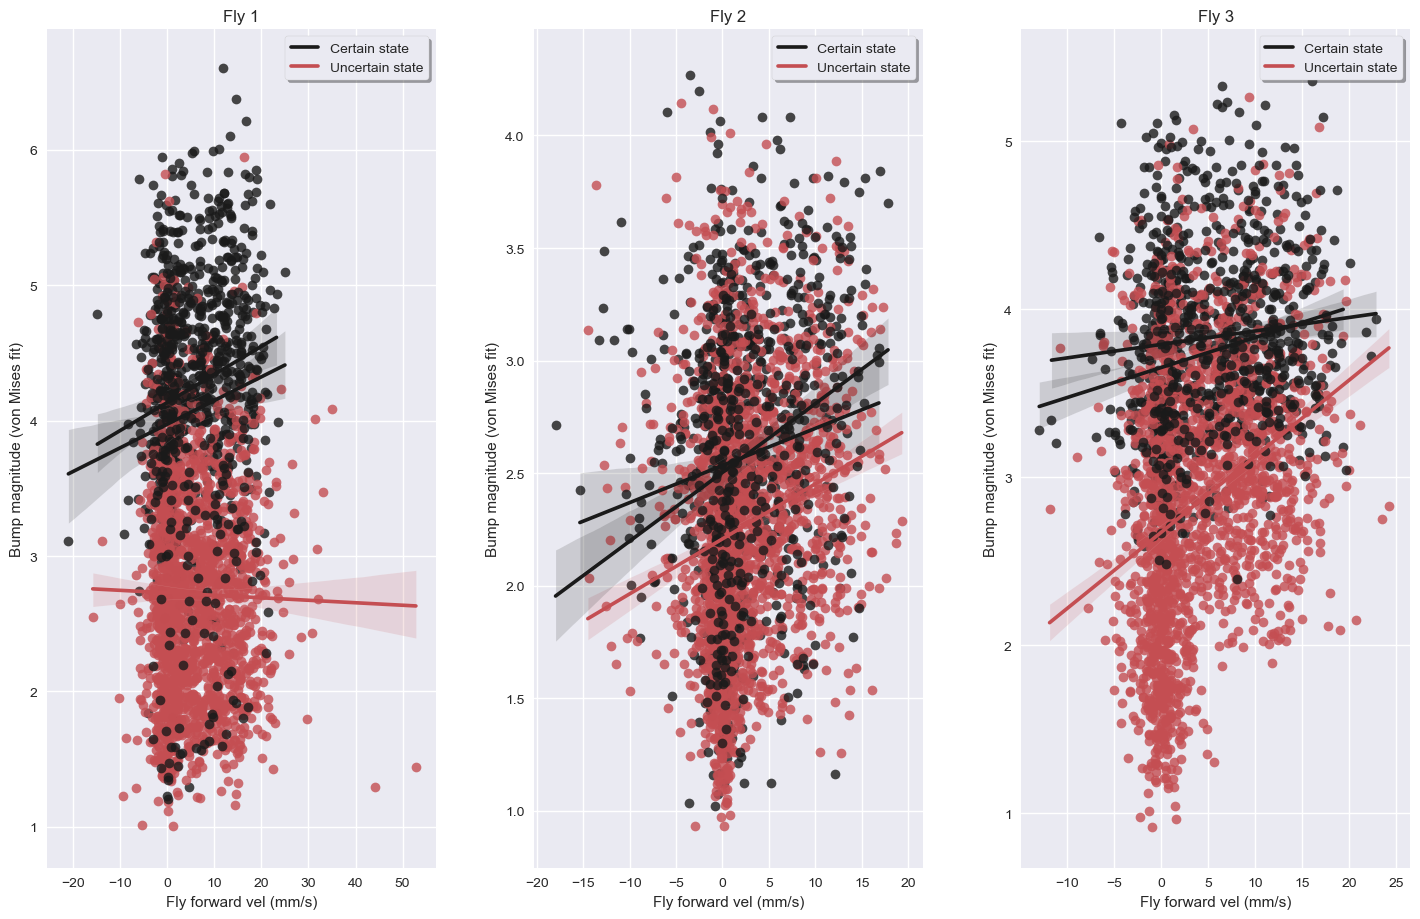

In [61]:
#Trying to add a regression to the data

fig = plt.figure(figsize = (15, 10), dpi=100)
for fly in range(flyNum):
    ax = fig.add_subplot(1, 3, fly+1)
    ax=sns.regplot(4.5*(flyGroupData[0,fly]['for_vel'][0:np.asscalar(flyGroupData[0,fly]['StartDarkness'])]),bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)] ,color='k')
    ax=sns.regplot(4.5*(flyGroupData[0,fly]['for_vel'][np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])]),bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,color='r')
    ax=sns.regplot(4.5*(flyGroupData[0,fly]['for_vel'][np.asscalar(flyGroupData[0,fly]['EndDarkness']):]),bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)] ,color='k')  
    plt.xlabel('Fly forward vel (mm/s)')
    plt.ylabel('Bump magnitude (von Mises fit)')
    plt.title('Fly ' + str(fly+1))
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')

fig.tight_layout(pad=3.0)


In [34]:
#For now, let's import the binned fwd vel data from matlab

os.chdir(mainDir + '\data\\') #move inside of the folder, inside the dark trial folder
binnedFVData = sio.loadmat('binnedFwdVelData.mat', struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
medianCertainFV = binnedFVData['medianCertainBin'] 
medianUncertainFV = binnedFVData['medianUncertainBin'] 
steCertainFV = binnedFVData['steCertainBin'] 
steUncertainFV = binnedFVData['steUncertainBin'] 


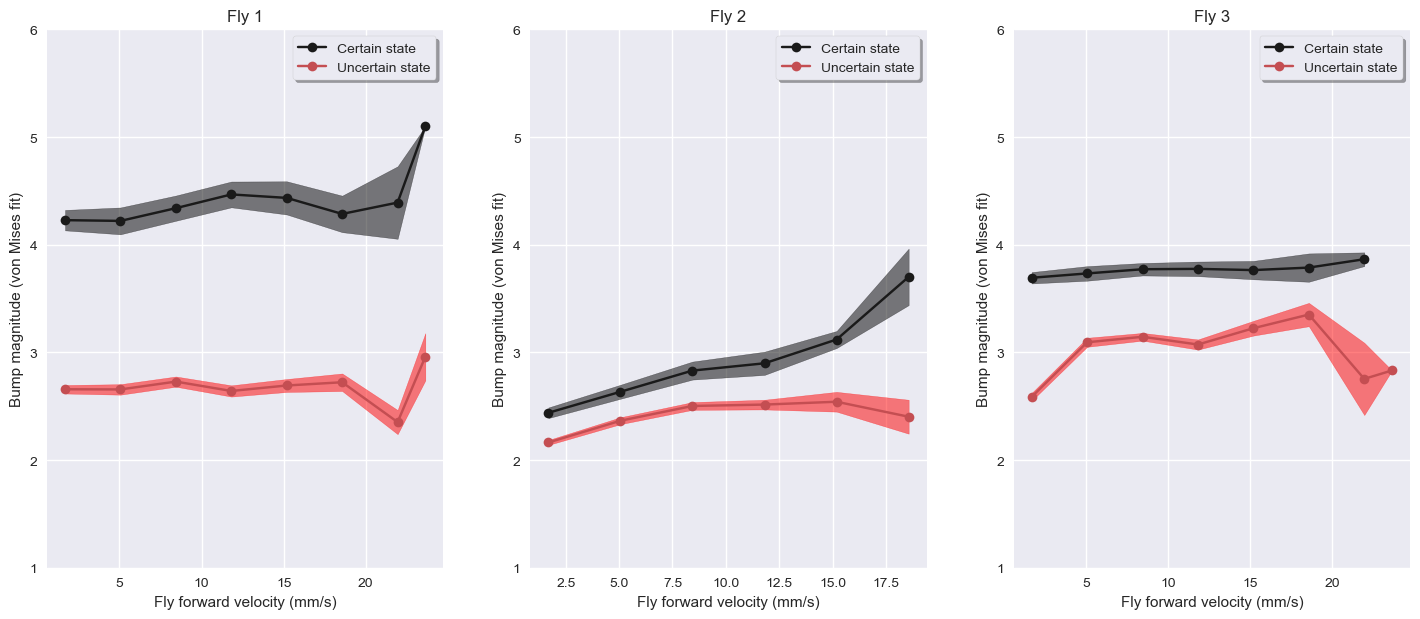

In [35]:
# Let's plot it

velBins = [1.6875, 5.0625, 8.4375, 11.8125, 15.1875, 18.5625, 21.9375, 23.625]

fig = plt.figure(figsize = (15, 7), dpi=100)

for fly in range(flyNum):
    ax = fig.add_subplot(1, flyNum, fly+1)
    ax.plot(velBins, np.squeeze(medianCertainFV[0,fly]), 'ko-')
    ax.fill_between(velBins, np.squeeze(medianCertainFV[0,fly])-np.squeeze(steCertainFV[0,fly]), np.squeeze(medianCertainFV[0,fly])+np.squeeze(steCertainFV[0,fly]),color='black',alpha=0.5)
    ax.plot(velBins, np.squeeze(medianUncertainFV[0,fly]), 'ro-')
    ax.fill_between(velBins, np.squeeze(medianUncertainFV[0,fly])-np.squeeze(steUncertainFV[0,fly]), np.squeeze(medianUncertainFV[0,fly])+np.squeeze(steUncertainFV[0,fly]),color='red',alpha=0.5)    
    plt.xlabel('Fly forward velocity (mm/s)')
    plt.ylabel('Bump magnitude (von Mises fit)')
    plt.title('Fly ' + str(fly+1))
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')
    ax.set_ylim([1,6])

fig.tight_layout(pad=3.0)

plt.savefig(mainDir + "\plots\BinnedBumpMagVsFwdVel.png", dpi=150)

In [42]:
#Let's look at the fly angular speed and forward vel per state

flyFwdVel = []

for fly in range(flyNum):
        flyFwdVel.extend(flyGroupData[0,fly]['for_vel'][0:np.asscalar(flyGroupData[0,fly]['StartDarkness'])])
        flyFwdVel.extend(flyGroupData[0,fly]['for_vel'][np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])])
        flyFwdVel.extend(flyGroupData[0,fly]['for_vel'][np.asscalar(flyGroupData[0,fly]['EndDarkness']-1):-1])

bumpDF['flyFwdVel'] = flyFwdVel

plt.style.use('seaborn')

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

bumpDF.groupby(['State','Fly ID'])[['flyAngSpeed']].median().unstack().plot(marker="o", ax=ax1)
ax1.set_ylabel('Fly angular speed',fontsize=15)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['Certain','Uncertain','Certain'],fontsize=15)
ax1.legend(['Fly 1', 'Fly 2', 'Fly 3'])
ax1.set_xlim(0.5,3.5)

bumpDF.groupby(['State','Fly ID'])[['flyFwdVel']].median().unstack().plot(marker="o", ax=ax2)
ax2.set_ylabel('Fly forward velocity', fontsize=15)
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(['Certain','Uncertain','Certain'],fontsize=15)
ax2.legend(['Fly 1', 'Fly 2', 'Fly 3'])
ax2.set_xlim(0.5,3.5)
#ax2.set_ylim(15,30)

plt.gcf().set_size_inches(15, 8)
#plt.savefig(mainDir + "\plots\medianFitValuesMatlab.png", dpi=150)

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


TypeError: float() argument must be a string or a number, not 'list'

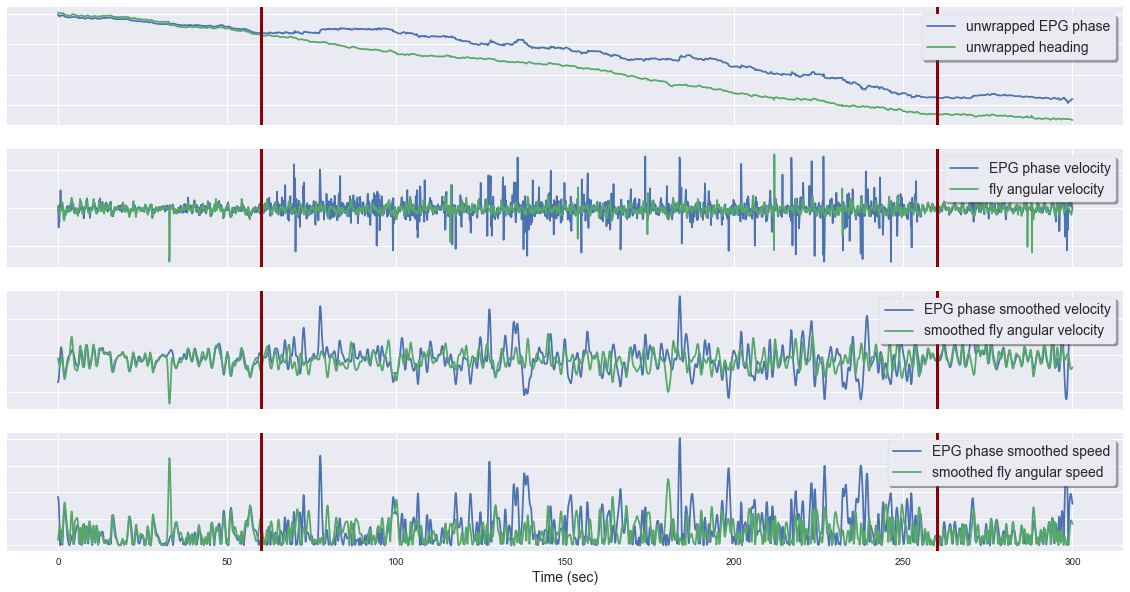

In [41]:
# Let's now analyze bump angular speed per state

#initialize arrays
unwrappedPhase = np.zeros((flyNum,frames))
diffUnwrapped = np.zeros((flyNum,frames))
smoothedDiff2 = np.zeros((flyNum,frames))

# Get the bump's angular speed
for fly in range(flyNum):
    unwrappedPhase[fly] = np.unwrap(flyGroupData[0,fly]['phase_value'])
    diffUnwrapped[fly] = np.append(0,np.ediff1d(unwrappedPhase[fly])*frames/300) #get phase velocity
    smoothedDiff2[fly] = gaussian_filter(diffUnwrapped[fly], sigma=3) #does this sigma represent frames? How do I choose the appropriate one?
#I don't think this is a great smoothing, I need to check.

# Let's do the same for the fly angular speed and compare
unwrappedHeading = np.zeros((flyNum,frames))
diffUnwrappedHeading = np.zeros((flyNum,frames))
smoothedDiff2Heading = np.zeros((flyNum,frames))

# Get the bump's angular speed
for fly in range(flyNum):
    unwrappedHeading[fly] = np.unwrap(flyGroupData[0,fly]['panel_angle'])
    diffUnwrappedHeading[fly] = np.append(0,np.ediff1d(unwrappedHeading[fly])*frames/300) #get phase velocity
    smoothedDiff2Heading[fly] = gaussian_filter(diffUnwrappedHeading[fly], sigma=3) #does this sigma represent frames? How do I choose the appropriate one?
#I don't think this is a great smoothing, I need to check.



fig,
ax1 = plt.subplot(411)
ax1.plot(totalTime,unwrappedPhase[0])
ax1.plot(totalTime,unwrappedHeading[0])
ax1.legend(['unwrapped EPG phase','unwrapped heading'], loc='upper right', frameon='True', shadow = 'True',fontsize=14)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.axvline(x=60, linewidth=3, color='darkred')
plt.axvline(x=260, linewidth=3, color='darkred')

ax2 = plt.subplot(412)
ax2.plot(totalTime,diffUnwrapped[0])
ax2.plot(totalTime,diffUnwrappedHeading[0])
ax2.legend(['EPG phase velocity','fly angular velocity'], loc='upper right', frameon='True', shadow = 'True',fontsize=14)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
plt.axvline(x=60, linewidth=3, color='darkred')
plt.axvline(x=260, linewidth=3, color='darkred')

ax3 = plt.subplot(413)
ax3.plot(totalTime,smoothedDiff2[0])
ax3.plot(totalTime,smoothedDiff2Heading[0])
ax3.legend(['EPG phase smoothed velocity','smoothed fly angular velocity'], loc='upper right', frameon='True', shadow = 'True',fontsize=14)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
plt.axvline(x=60, linewidth=3, color='darkred')
plt.axvline(x=260, linewidth=3, color='darkred')

ax4 = plt.subplot(414)
ax4.plot(totalTime,abs(smoothedDiff2[0]))
ax4.plot(totalTime,abs(smoothedDiff2Heading[0]))
ax4.legend(['EPG phase smoothed speed','smoothed fly angular speed'], loc='upper right', frameon='True', shadow = 'True',fontsize=14)
ax4.set_xlabel('Time (sec)',fontsize=14)
ax4.set_yticklabels([])
plt.axvline(x=60, linewidth=3, color='darkred')
plt.axvline(x=260, linewidth=3, color='darkred')

plt.gcf().set_size_inches(20, 10)

plt.savefig(mainDir + "\plots\BumpSpeedFlySpeed.png", dpi=150)


# Add to data frame
bumpAngSpeed = abs(np.rad2deg(np.reshape(smoothedDiff2,3*frames)))
bumpDF['bumpAngSpeed'] = bumpAngSpeed

flyAngSpeed = abs(np.rad2deg(np.reshape(smoothedDiff2Heading,3*frames)))
bumpDF['flyAngSpeed'] = flyAngSpeed



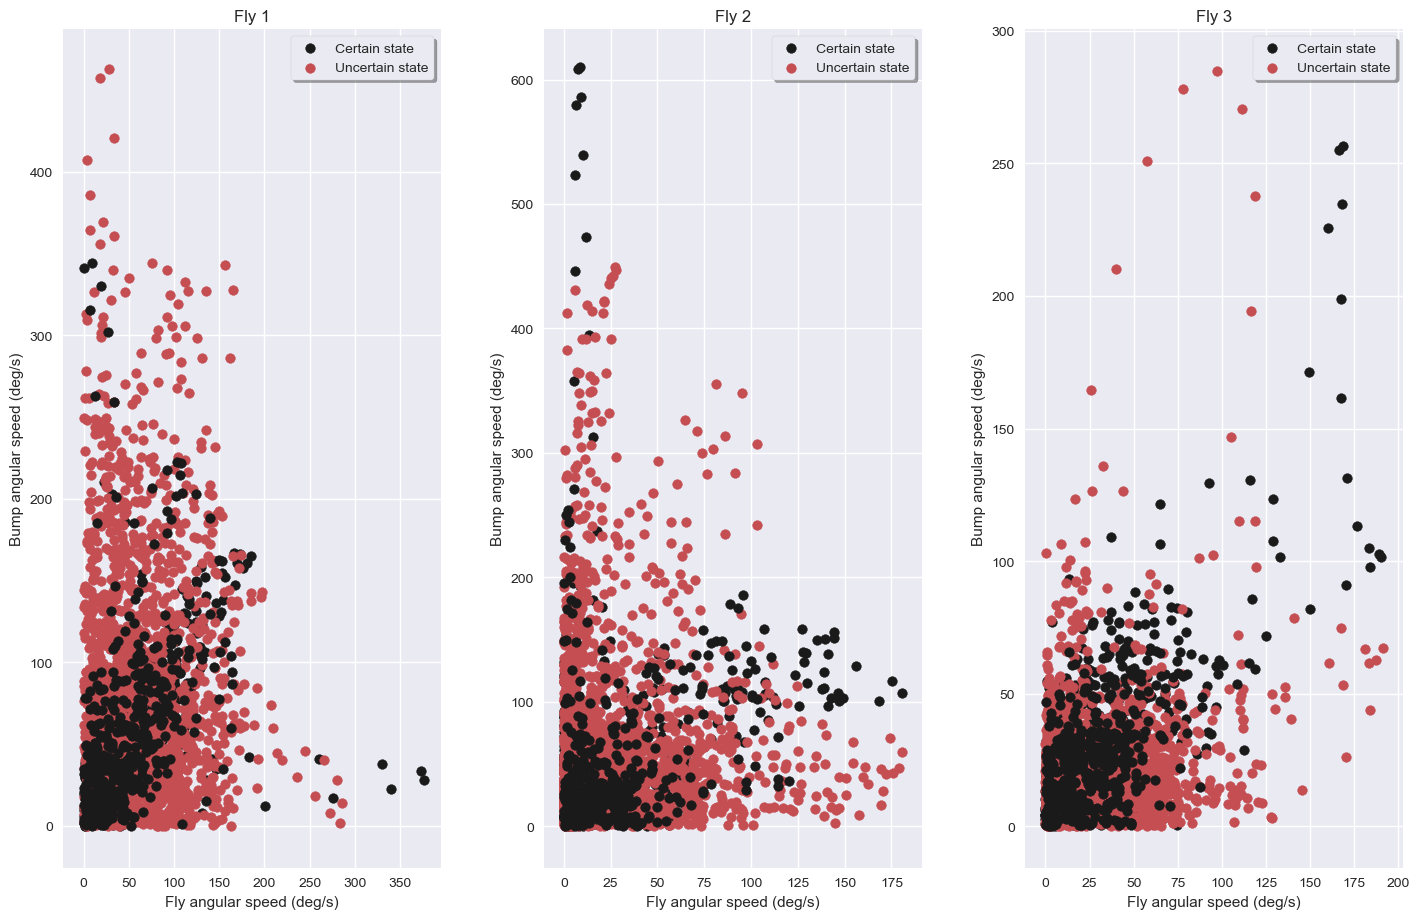

In [43]:
fig = plt.figure(figsize = (15, 10), dpi=100)

for fly in range(flyNum):
    ax = fig.add_subplot(1, 3, fly+1)
    ax.scatter(flyAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)] ,c='k')
    ax.scatter(flyAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,c='r')
    ax.scatter(flyAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)] ,c='k')  
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump angular speed (deg/s)')
    plt.title('Fly ' + str(fly+1))
   # plt.xlim([0,30])
   # plt.ylim([0,50])
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')
    fig.tight_layout(pad=3.0)
    
plt.savefig(mainDir + "\plots\BumpSpeedVsFlySpeed.png", dpi=150)

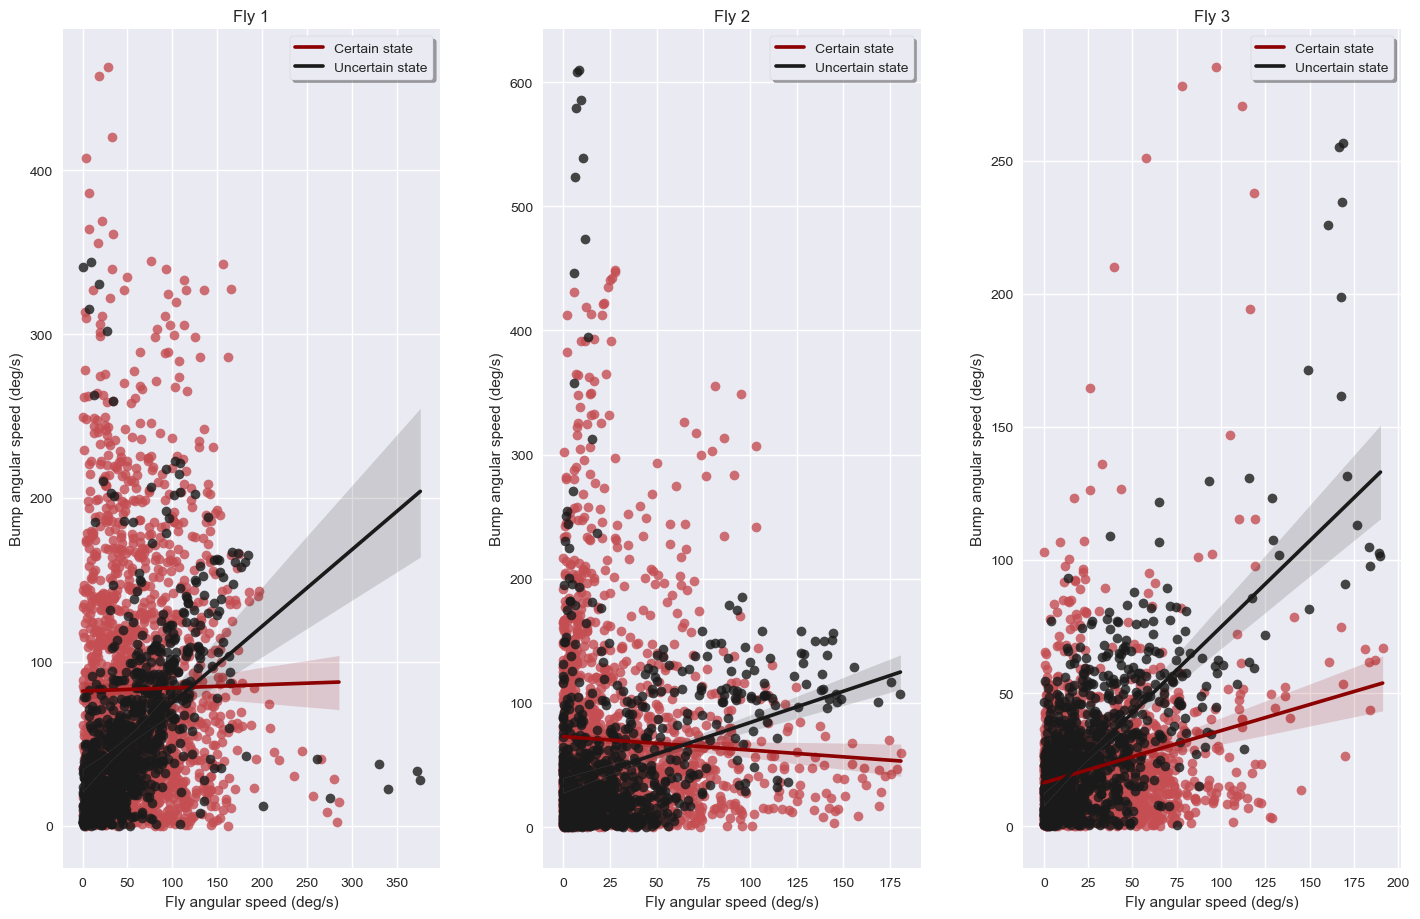

In [65]:
#Let's fit a regression to this data and plot it?

fig = plt.figure(figsize = (15, 10), dpi=100)

for fly in range(flyNum):
    ax = fig.add_subplot(1, 3, fly+1)
    ax=sns.regplot(flyAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,scatter_kws={"color": "r"}, line_kws={"color": "darkred"})
    ax=sns.regplot(flyAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] != 2)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] != 2) ] ,color='k')
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump angular speed (deg/s)')
    plt.title('Fly ' + str(fly+1))
   # plt.xlim([0,30])
   # plt.ylim([0,50])
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')
    fig.tight_layout(pad=3.0)
    
plt.savefig(mainDir + "\plots\BumpSpeedVsFlySpeedWithReg.png", dpi=150)

In [66]:
# Binning the fly angular speed
#add fly speed data to the data frame


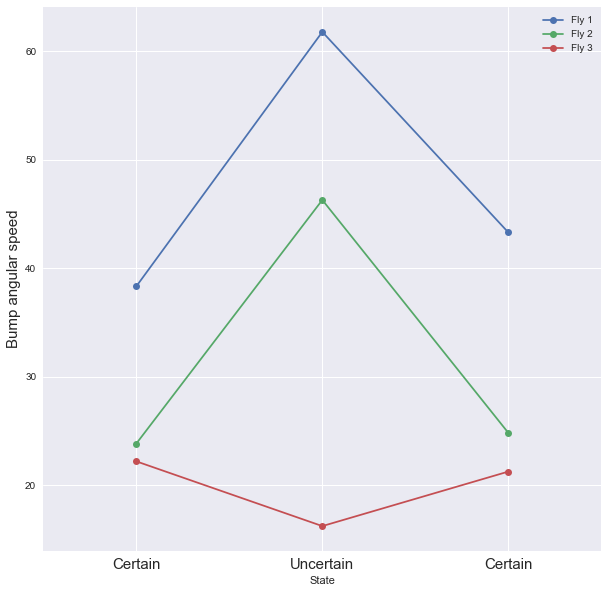

In [67]:
# Let's look at the relationship between bump speed and state

bumpDF.groupby(['State','Fly ID'])[['bumpAngSpeed']].median().unstack().plot(marker="o")
plt.ylabel('Bump angular speed', fontsize=15)
plt.xticks([1,2,3], ['Certain','Uncertain','Certain'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'])
plt.xlim(0.5,3.5)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\plots\BumpSpeedWithState.png", dpi=150)


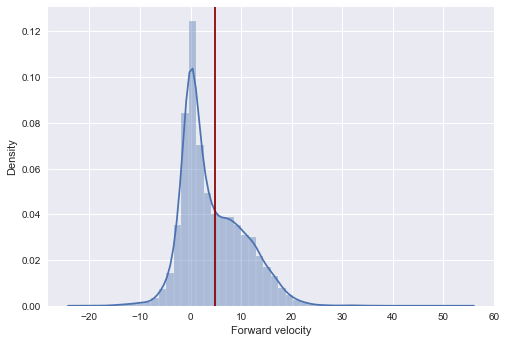

In [68]:
# Diving the data in standing and walking bouts

# Get all the forward velocities and plot histogram
allWalkingVelocities = 4.5*(np.concatenate((flyGroupData[0,0]['for_vel'],flyGroupData[0,1]['for_vel'],flyGroupData[0,2]['for_vel'])))
densityVal = np.asarray(sns.distplot(allWalkingVelocities).get_lines()[0].get_data())
plt.xlabel('Forward velocity')
plt.ylabel('Density')


# Determine the threshold between standing and moving as the valley between the two peaks in the distribution
I = np.argmax(densityVal[1,:],axis=0)
I2 = np.argmin(abs(densityVal[1,I:]-(densityVal[1,I]/2)),axis=0)+1
thresholdVel = densityVal[0,I+I2+1]

plt.axvline(x=thresholdVel,color='darkred')
plt.savefig(mainDir + "\plots\VelThreshold.png", dpi=150)


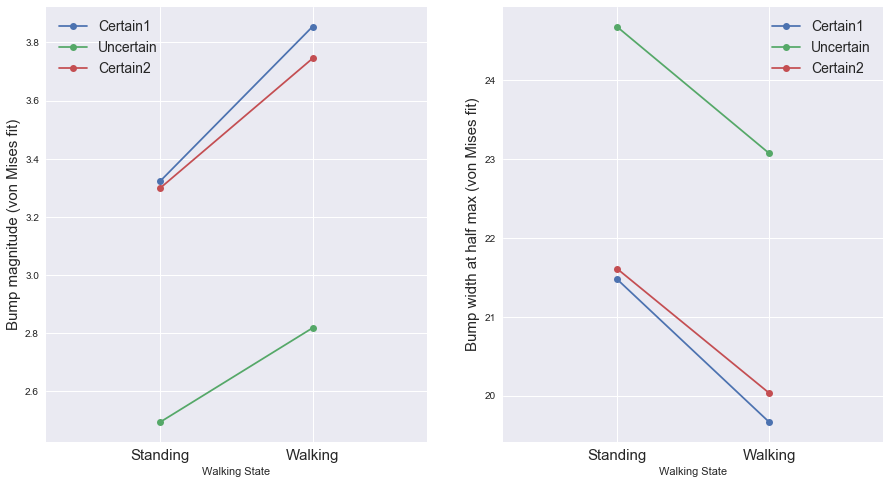

In [69]:
# Get and plot bump magnitude and width at half max in walking and standing bouts for every state

#Find data points above the velocity threshold
walkingBouts = allWalkingVelocities>thresholdVel
bumpDF['Walking State'] = walkingBouts

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

bumpDF.groupby(['Walking State','State'])[['bumpMagFit']].mean().unstack().plot(marker='o',ax=ax1)
ax1.set_ylabel('Bump magnitude (von Mises fit)', fontsize=15)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Standing','Walking'],fontsize=15)
ax1.legend(['Certain1', 'Uncertain', 'Certain2'],fontsize=14,loc=2)
ax1.set_xlim(-0.75,1.75)

bumpDF.groupby(['Walking State','State'])[['bumpHWFit']].mean().unstack().plot(marker='o',ax=ax2)
ax2.set_ylabel('Bump width at half max (von Mises fit)', fontsize=15)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Standing','Walking'],fontsize=15)
ax2.legend(['Certain1', 'Uncertain', 'Certain2'],fontsize=14)
ax2.set_xlim(-0.75,1.75)

plt.gcf().set_size_inches(15, 8)


plt.savefig(mainDir + "\plots\BumpWithWalkingState.png", dpi=150)

In [ ]:
#Fly speed vs state

